In [1]:
import sys
sys.path.append("/home/ec2-user/jupyter/Ancillary_tools/CPT_Vsz_Vs30")
sys.path.append("/home/ec2-user/jupyter/Ancillary_tools")


from collections import Counter
import os
from pathlib import Path



from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from qcore import geo


from sqlalchemy import Column, ForeignKey, Integer, String, Float
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship

from sqlalchemy import create_engine, desc
from sqlalchemy.orm import sessionmaker
from getCPTdata import getCPTdata
from computeVs import Vs_McGann
from computeVsz import compute_vsz_from_vs
from computeVs30 import vsz_to_vs30

from loc_filter import locs_multiple_records


out_dir = Path("/home/ec2-user/jupyter/cpt/outdir")
plot_dir = out_dir / "validation_plots"



results = {}

skipped_fp = open(out_dir / "skipped_cpts" / f"skipped_cpts", "w")



engine = create_engine('sqlite:///cpt/nz_cpt.db')

DBSession = sessionmaker(bind=engine)
session = DBSession()
                


def log_error(skipped_fp, cpt_name, error):
    skipped_fp.write(f"{cpt_name} - {error}\n")


def count_digits(arr):
    stringified = str(arr).replace("0", "").replace(".", "")
    return Counter(stringified)


Base = declarative_base()

class CPTLocation(Base):
    __tablename__ = 'cpt_location'
    # Here we define columns for the table person
    # Notice that each column is also a normal Python instance attribute.
    id = Column(Integer, primary_key=True)
    #    customer_id=Column(Integer, ForeignKey('customers.id'))
    name = Column(String(20), nullable=False)  # 20210427_17
    private = Column(Integer) #true / false
    type = Column(String(5)) # CPT or SCPT
    nztm_x = Column(Float)
    nztm_y = Column(Float)

    def __iter__(self): #overridding this to return tuples of (key,value)
        return iter([('id',self.id),('name',self.name),('nztm_x',self.nztm_x),('nztm_y',self.nztm_y)])


class CPTDepthRecord(Base):
    __tablename__ = 'cpt_depth_record'
    # Here we define columns for the table person
    # Notice that each column is also a normal Python instance attribute.
    id = Column(Integer, primary_key=True)
    cpt_name = Column(String(20), nullable=False)  # 
    depth = Column(Float) #
    qc = Column(Float) #
    fs = Column(Float)
    u = Column(Float)
    loc_id = Column(Integer, ForeignKey('cpt_location.id'))
    
    def __iter__(self): #overridding this to return tuples of (key,value)
        return iter([('id',self.id),('depth',self.depth),('qc',self.qc),('fs',self.fs),('u',self.u),('loc_id',self.loc_id)])


    


In [2]:
def max_depth_record(cpt_name):
    res=session.query(CPTDepthRecord).filter(CPTDepthRecord.cpt_name == cpt_name).order_by(CPTDepthRecord.depth.desc()).first()
    return dict(res)
def cpt_records(cpt_name):
    res=session.query(CPTDepthRecord).filter(CPTDepthRecord.cpt_name == cpt_name).all()
    return res

def cpt_locations():
    return session.query(CPTLocation).all()

def cpt_records_exists(cpt_name):
    res=session.query(CPTDepthRecord).filter(CPTDepthRecord.cpt_name == cpt_name).first()
    return (res is not None)

def get_cpt_data(cpt_name, columnwise=True):
    res=session.query(CPTDepthRecord.depth,CPTDepthRecord.qc,CPTDepthRecord.fs,CPTDepthRecord.u).filter(CPTDepthRecord.cpt_name == cpt_name).all()
    res_array =np.array(res)
    if columnwise:
        res_array = res_array.T
    return res_array    

In [10]:
cpt_records_exists("CPT_108566")


False

In [4]:
get_cpt_data("CPT_101346")


array([], dtype=float64)

In [5]:
%%time
locs = cpt_locations()
print(dict(locs[0]))


{'id': 1, 'name': 'CPT_1', 'nztm_x': 1576467.294706431, 'nztm_y': 5181262.382226084}
CPU times: user 1.1 s, sys: 59.8 ms, total: 1.16 s
Wall time: 1.26 s


In [6]:
%%time
print(max_depth_record('SCPT_140251'))


{'id': 1034, 'depth': 20.69, 'qc': 22.7256, 'fs': 1.0416, 'u': -0.0251, 'loc_id': 39741}
CPU times: user 7.75 ms, sys: 53 µs, total: 7.8 ms
Wall time: 7.64 ms


In [7]:
%%time
res=cpt_records('SCPT_140251')
print(res[0].cpt_name)

SCPT_140251
CPU times: user 21 ms, sys: 10 µs, total: 21 ms
Wall time: 24 ms


In [8]:
#this takes a while...
dup_locs = []
dup_locs=locs_multiple_records(locs, stdout=True) #dup_locs is a dictionary {loc0:[loc00,loc01],loc1:[loc10,loc11,loc12],loc2:[loc20]...} 
import functools,operator
dup_locs = functools.reduce(operator.iconcat, list(dup_locs.values()), []) #flattens dictionary into lists. [loc00,loc01,loc10,loc11,loc12,loc20...]
#note that loc0,loc1 are not in dup_locs. These locations are to be processed. Duplicates are to be skipped


CPT_10002         172.64549432844217 -43.52471638225848
===1. CPT_6445     172.64549432844217 -43.52471638225848 (dist:0.000000)
CPT_10005         172.63719404833557 -43.52558790573636
===1. CPT_9747     172.63719404833557 -43.52558790573636 (dist:0.000000)
===2. CPT_9780     172.63719404833557 -43.52558790573636 (dist:0.000000)
CPT_10018         172.67399226934313 -43.51533677408961
===1. CPT_17195    172.67399226934313 -43.51533677408961 (dist:0.000000)
CPT_100487        172.6795963849534 -43.55151192551167
===1. CPT_87923    172.6795963849534 -43.55151192551167 (dist:0.000000)
CPT_100496        172.6421776474338 -43.516392914368566
===1. CPT_88242    172.6421776474338 -43.516392914368566 (dist:0.000000)
CPT_1010          172.6512779079427 -43.54089594133181
===1. CPT_502      172.6512779079427 -43.54089594133181 (dist:0.000000)
CPT_101058        172.7037279706582 -43.57404493171889
===1. CPT_103746   172.70372802656306 -43.57404496885039 (dist:0.000006)
CPT_101059        172.7037659

===1. CPT_137379   168.32756621878497 -46.59495467529442 (dist:0.000000)
CPT_13738         172.6916999999901 -43.51660000288212
===1. CPT_13740    172.6916999999901 -43.51660000288212 (dist:0.000000)
CPT_137381        168.32700421831225 -46.59470367537645
===1. CPT_137382   168.32700421831308 -46.5947036753771 (dist:0.000000)
===2. CPT_137386   168.32700421831552 -46.594703675378966 (dist:0.000000)
CPT_13752         172.68109999998973 -43.55900000289149
===1. CPT_13754    172.68109999998973 -43.55900000289149 (dist:0.000000)
CPT_137528        174.77725113765013 -41.29586576130877
===1. CPT_137529   174.77725113765013 -41.2958657613088 (dist:0.000000)
CPT_137647        174.85790037720176 -41.125604920259526
===1. CPT_137648   174.85790037720176 -41.12560492025953 (dist:0.000000)
CPT_138116        176.86598829753018 -37.946336005928096
===1. CPT_138117   176.86598829753018 -37.946336005928096 (dist:0.000000)
CPT_13821         172.6922833313757 -43.47922251615802
===1. CPT_15824    172.69

CPT_46262         172.707984475199 -43.28347149857265
===1. CPT_46263    172.707984475199 -43.28347149857265 (dist:0.000000)
CPT_46265         172.70715785727097 -43.28364047342705
===1. CPT_46266    172.70715785727097 -43.28364047342705 (dist:0.000000)
CPT_46267         172.63378331126523 -43.52498818339101
===1. CPT_49040    172.63378299998826 -43.52498800288397 (dist:0.000032)
CPT_46268         172.63421194135495 -43.524992166705744
===1. CPT_49041    172.63421199998825 -43.52499200288396 (dist:0.000019)
CPT_46269         172.63402657645668 -43.524991213363876
===1. CPT_49042    172.63402699998827 -43.52499100288396 (dist:0.000041)
CPT_463           172.63028333012315 -43.53647305962705
===1. CPT_464      172.63028333012315 -43.53647305962705 (dist:0.000000)
CPT_465           172.63370403033213 -43.53621396270063
===1. CPT_466      172.63370403033213 -43.53621396270063 (dist:0.000000)
CPT_46635         172.50185226615176 -43.68540513886205
===1. CPT_50126    172.50185226615176 -43.6

===1. CPT_88526    172.64676863832756 -43.517713717329414 (dist:0.000009)
CPT_87841         174.86410853511288 -36.87658645187279
===1. CPT_87842    174.86410853511288 -36.87658645187279 (dist:0.000000)
CPT_87848         174.86585492417183 -36.87735220447916
===1. CPT_87849    174.86585492417183 -36.87735220447916 (dist:0.000000)
CPT_8787          172.63899999998844 -43.52230000288336
===1. CPT_8788     172.63899999998844 -43.52230000288336 (dist:0.000000)
CPT_87888         174.87279446271705 -36.86978904464722
===1. CPT_87894    174.87279446271705 -36.86978904464722 (dist:0.000000)
CPT_87896         174.87085488682277 -36.87121665866433
===1. CPT_87897    174.87085488682277 -36.87121665866433 (dist:0.000000)
CPT_87931         174.86161534941513 -36.87971709787174
===1. CPT_87932    174.86161534941513 -36.87971709787174 (dist:0.000000)
CPT_8794          172.63989599998843 -43.538020002886846
===1. CPT_8803     172.63989599998843 -43.538020002886846 (dist:0.000000)
CPT_8817          172

CPT_TT40288       172.65493860522724 -43.31346220765315
===1. CPT_TT40289  172.65493860522724 -43.31346220765315 (dist:0.000000)
CPT_TT40291       172.6559658526687 -43.31498707677206
===1. CPT_TT40292  172.6559658526687 -43.31498707677206 (dist:0.000000)
CPT_TT40295       172.65314964097473 -43.31361887929677
===1. CPT_TT40296  172.65314964097473 -43.31361887929677 (dist:0.000000)
CPT_TT40297       172.6578063491097 -43.314443318207196
===1. CPT_TT40298  172.6578063491097 -43.314443318207196 (dist:0.000000)
CPT_TT40299       172.65660146986056 -43.31598849546482
===1. CPT_TT40300  172.65660146986056 -43.31598849546482 (dist:0.000000)
CPT_TT40301       172.65553381074062 -43.31724592638287
===1. CPT_TT40302  172.65553381074062 -43.31724592638287 (dist:0.000000)
CPT_TT40303       172.65445254543692 -43.312191093593164
===1. CPT_TT40304  172.65445254543692 -43.312191093593164 (dist:0.000000)
CPT_TT40548       172.65410375183225 -43.31281135585167
===1. CPT_TT40549  172.65410375183225 -43

In [16]:
print(dup_locs)

['CPT_6445', 'CPT_9747', 'CPT_9780', 'CPT_17195', 'CPT_87923', 'CPT_88242', 'CPT_502', 'CPT_103746', 'CPT_103747', 'CPT_9712', 'CPT_1025', 'CPT_102430', 'CPT_102526', 'CPT_1027', 'CPT_103206', 'CPT_10330', 'CPT_10350', 'CPT_10387', 'CPT_10412', 'CPT_TT108427', 'CPT_TT108432', 'CPT_TT108435', 'CPT_104390', 'CPT_128504', 'CPT_105230', 'CPT_10528', 'CPT_11189', 'CPT_TT5406', 'CPT_TT5408', 'CPT_1057', 'CPT_115687', 'CPT_105961', 'CPT_106025', 'CPT_106286', 'CPT_106287', 'CPT_110692', 'CPT_108483', 'CPT_108484', 'CPT_108485', 'CPT_108486', 'CPT_108487', 'CPT_108488', 'SCPT_108035', 'CPT_108131', 'CPT_108134', 'CPT_108219', 'CPT_10863', 'CPT_TT63931', 'CPT_TT63925', 'CPT_TT63930', 'CPT_TT63929', 'CPT_TT63933', 'CPT_TT63974', 'CPT_TT63975', 'CPT_TT63976', 'CPT_TT63977', 'CPT_TT63979', 'CPT_TT63980', 'CPT_TT63982', 'CPT_TT63986', 'CPT_TT63987', 'CPT_TT63988', 'CPT_TT63990', 'CPT_TT63992', 'CPT_TT63934', 'CPT_TT63994', 'CPT_108377', 'CPT_55511', 'CPT_86986', 'CPT_134132', 'CPT_134131', 'CPT_150

In [9]:
%%time
for row_n, loc in enumerate(locs):
    
    cpt_name = loc.name
    if not cpt_records_exists(cpt_name):
        log_error(skipped_fp, cpt_name, f"No record found: {cpt_name}")
        continue
    
    print(row_n,cpt_name)
    
    z, qc, fs, u2 = get_cpt_data(cpt_name)
     

    # duplicate location
    if cpt_name in dup_locs:
        log_error(skipped_fp, cpt_name, f"Duplicate location")
        continue

    # duplicate depth check
    u, c = np.unique(z, return_counts=True)
    if np.any([c > 1]):
        log_error(skipped_fp, cpt_name, f"Duplicate depth detected - invalid CPT")
        continue

    # Check for invalid negative readings
    if any(fs < -0.2) or any(qc < -0.2) or any(u2 < -0.2):
        log_error(skipped_fp, cpt_name, f"negative value - discarding")
        continue

    # Check for repeated digits
    if any(value > 3 for fs_value in fs for value in count_digits(fs_value).values()):
        log_error(skipped_fp, cpt_name, f"Repeated digit - investigating")
        continue

    max_depth = max(z)
    if max_depth < 5:
        log_error(skipped_fp, cpt_name, f"depth<5: {max_depth}")
        continue
    min_depth = min(z)
    z_span = max_depth - min_depth
    if z_span < 5:
        log_error(skipped_fp, cpt_name, f"depth range <5: {z_span}")
        continue
    (z, Vs, Vs_SD) = Vs_McGann(z, qc, fs)
    Vsz, max_depth = compute_vsz_from_vs(Vs, z)
    vs30 = vsz_to_vs30(Vsz, z)

    vs30_result = {}
    vs30_result["NZTM_X"] = loc.nztm_x
    vs30_result["NZTM_Y"] = loc.nztm_y
    vs30_result["Vsz"] = Vsz
    vs30_result["Vs30"] = vs30
    vs30_result["Zmax"] = max_depth
    vs30_result["Zmin"] = min_depth
    vs30_result["Zspan"] = z_span
    results[cpt_name] = vs30_result
    if row_n < 10:
        fig, ax = plt.subplots()
        ax.plot(fs, z)
        ax.invert_yaxis()
        ax.set_ylabel("Depth")
        ax.set_xlabel("fs")
        ax.grid()
        fig.savefig(plot_dir / f"{cpt_name}_fs.png")
        plt.close(fig)

        fig, ax = plt.subplots()
        lowerVs = np.exp(np.log(Vs) - Vs_SD)
        upperVs = np.exp(np.log(Vs) + Vs_SD)
        ax.plot(Vs, z, "red")
        ax.plot(lowerVs, z, "r--", linewidth=0.5)
        ax.plot(upperVs, z, "r--", linewidth=0.5)
        ax.grid()
        ax.invert_yaxis()
        ax.set_ylabel("Depth")
        ax.set_xlabel("Vs (m/s)")
        ax.set_xlim(0, 600)
        fig.savefig(plot_dir / f"{cpt_name}_Vs.png")
        plt.close(fig)
    elif row_n > 0:
        pass
    else:
        break




0 CPT_1
1 CPT_10
2 CPT_100
3 CPT_1000
4 CPT_10001


/home/ec2-user/jupyter/Ancillary_tools/CPT_Vsz_Vs30/calculations.py:22: RuntimeWarning: invalid value encountered in true_divide
  tn = dn / vn
/home/ec2-user/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/home/ec2-user/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log


5 CPT_10002
6 CPT_10003
7 CPT_10004
8 CPT_10005
9 CPT_10006
10 CPT_10007
11 CPT_10008
12 CPT_1001
13 CPT_10010
14 CPT_10011
15 CPT_10012
16 CPT_10013
17 CPT_10014
18 CPT_10018
19 CPT_1002
20 CPT_10020
21 CPT_10021
22 CPT_10022
23 CPT_10023
24 CPT_10024
25 CPT_10025
26 CPT_1003
27 CPT_10032
28 CPT_100360
29 CPT_100361
30 CPT_100362
31 CPT_100371
32 CPT_100372
33 CPT_100374
34 CPT_100375
35 CPT_100380
36 CPT_10039
37 CPT_1004
38 CPT_10043
39 CPT_100454
40 CPT_100457
41 CPT_100460
42 CPT_100462
43 CPT_100463
44 CPT_100464
45 CPT_100465
46 CPT_100466
47 CPT_100467
48 CPT_100468
49 CPT_100469
50 CPT_10047
51 CPT_100470
52 CPT_100471
53 CPT_100472
54 CPT_100473
55 CPT_100474
56 CPT_100475
57 CPT_100476
58 CPT_100477
59 CPT_100478
60 CPT_100480
61 CPT_100481
62 CPT_100482
63 CPT_100483
64 CPT_100487
65 CPT_10049
66 CPT_100494
67 CPT_100496
68 CPT_1005
69 CPT_100515
70 CPT_100517
71 CPT_100518
72 CPT_100521
73 CPT_100522
74 CPT_100530
75 CPT_100532
76 CPT_100534
77 CPT_100537
78 CPT_10054
79 C

801 CPT_103325
802 CPT_103329
803 CPT_10333
804 CPT_103335
805 CPT_103336
806 CPT_103338
807 CPT_103339
808 CPT_10334
809 CPT_103340
810 CPT_103341
811 CPT_103342
812 CPT_103343
813 CPT_103344
814 CPT_103345
815 CPT_103347
816 CPT_103348
818 CPT_103352
819 CPT_103355
820 CPT_103356
821 CPT_103359
822 CPT_10336
823 CPT_103364
824 CPT_103369
825 CPT_10337
826 CPT_103371
827 CPT_103383
828 CPT_103385
829 CPT_103387
830 CPT_103388
831 CPT_103390
832 CPT_103391
833 CPT_103393
834 CPT_103396
835 CPT_1034
836 CPT_103400
837 CPT_103404
838 CPT_103405
839 CPT_103407
840 CPT_103409
841 CPT_103410
842 CPT_103412
843 CPT_103413
844 CPT_103418
845 CPT_103419
846 CPT_10342
847 CPT_103420
848 CPT_103421
849 CPT_103422
850 CPT_103423
851 CPT_103424
852 CPT_103425
853 CPT_103426
854 CPT_103435
855 CPT_103436
856 CPT_103437
857 CPT_103438
858 CPT_103439
859 CPT_103440
860 CPT_103441
861 CPT_103444
862 CPT_103446
863 CPT_103454
864 CPT_10346
865 CPT_103460
866 CPT_103461
867 CPT_103462
868 CPT_103463
869

1389 CPT_105011
1390 CPT_105016
1391 CPT_105017
1392 CPT_105018
1393 CPT_105019
1394 CPT_105020
1395 CPT_105021
1396 CPT_105022
1397 CPT_105023
1398 CPT_105024
1399 CPT_105025
1400 CPT_105034
1401 CPT_105035
1402 CPT_105047
1403 CPT_105048
1404 CPT_105049
1405 CPT_105050
1406 CPT_105051
1407 CPT_105060
1409 CPT_105073
1410 CPT_105074
1411 CPT_105075
1412 CPT_105076
1413 CPT_105077
1414 CPT_105078
1415 CPT_105079
1416 CPT_10508
1417 CPT_105080
1418 CPT_105081
1419 CPT_105082
1420 CPT_105083
1421 CPT_105084
1422 CPT_105085
1424 CPT_10509
1425 CPT_105090
1426 CPT_105091
1427 CPT_105092
1428 CPT_105093
1429 CPT_1051
1430 CPT_105108
1431 CPT_105109
1432 CPT_105110
1433 CPT_105111
1434 CPT_105112
1435 CPT_105126
1436 CPT_105127
1437 CPT_105164
1438 CPT_105165
1445 CPT_1052
1446 CPT_105220
1447 CPT_105228
1448 CPT_105229
1449 CPT_105230
1450 CPT_105231
1451 CPT_105244
1452 CPT_105245
1453 CPT_105246
1454 CPT_105247
1455 CPT_105248
1456 CPT_105249
1457 CPT_105250
1458 CPT_105269
1459 CPT_10527

2153 CPT_1072
2154 CPT_10723
2155 CPT_1073
2156 CPT_1074
2157 CPT_10741
2158 CPT_10742
2159 CPT_1075
2160 CPT_10751
2161 CPT_10753
2162 CPT_1076
2163 CPT_10762
2164 CPT_10765
2165 CPT_10767
2166 CPT_10768
2167 CPT_10769
2168 CPT_1077
2169 CPT_10771
2170 CPT_10772
2171 CPT_10773
2172 CPT_10774
2173 CPT_10775
2174 CPT_10779
2175 CPT_1078
2176 CPT_10782
2177 CPT_10783
2178 CPT_107849
2179 CPT_107850
2180 CPT_107851
2181 CPT_10788
2182 CPT_107880
2183 CPT_10789
2184 CPT_107892
2185 CPT_107893
2186 CPT_107895
2187 CPT_107896
2188 CPT_107897
2189 CPT_107898
2190 CPT_107899
2191 CPT_1079
2192 CPT_107900
2193 CPT_107901
2194 CPT_107907
2195 CPT_107908
2196 CPT_107909
2197 CPT_107919
2198 CPT_107923
2199 CPT_107927
2200 CPT_107929
2201 CPT_107930
2202 CPT_107931
2203 CPT_107932
2204 CPT_107933
2205 CPT_107934
2206 CPT_107953
2207 CPT_107954
2208 CPT_107955
2209 CPT_107958
2210 CPT_107959
2211 CPT_107960
2212 CPT_107994
2213 CPT_107995
2214 CPT_107996
2215 CPT_107997
2216 CPT_108
2217 CPT_1080
2

2951 CPT_110729
2952 CPT_11073
2953 CPT_110732
2954 CPT_110734
2955 CPT_110735
2956 CPT_110746
2957 CPT_110747
2958 CPT_110748
2959 CPT_110749
2960 CPT_11075
2961 CPT_110750
2962 CPT_110751
2963 CPT_110752
2964 CPT_110753
2965 CPT_110754
2966 CPT_110755
2967 CPT_110756
2968 CPT_110757
2969 CPT_110758
2970 CPT_110759
2971 CPT_11076
2972 CPT_110760
2973 CPT_110761
2974 CPT_110763
2975 CPT_110765
2976 CPT_110766
2977 CPT_110768
2978 CPT_11077
2979 CPT_110774
2980 CPT_110775
2981 CPT_110776
2982 CPT_110777
2983 CPT_11079
2984 CPT_1108
2985 CPT_11080
2986 CPT_11081
2987 CPT_110810
2988 CPT_110812
2989 CPT_110813
2990 CPT_110814
2991 CPT_11082
2992 CPT_11083
2993 CPT_11084
2994 CPT_110840
2995 CPT_110842
2996 CPT_110854
2997 CPT_11087
2998 CPT_110877
2999 CPT_110878
3000 CPT_11089
3001 CPT_110898
3002 CPT_110899
3003 CPT_1109
3004 CPT_11090
3005 CPT_110900
3006 CPT_110901
3007 CPT_110902
3008 CPT_110903
3009 CPT_11091
3010 CPT_110916
3011 CPT_110917
3012 CPT_110918
3013 CPT_110919
3014 CPT_1

3519 CPT_112580
3520 CPT_11259
3521 CPT_1126
3522 CPT_11260
3523 CPT_112603
3524 CPT_112612
3525 CPT_112630
3526 CPT_112633
3527 CPT_112634
3528 CPT_112639
3529 CPT_112640
3530 CPT_112641
3531 CPT_112642
3532 CPT_11267
3533 CPT_112675
3534 CPT_112676
3535 CPT_112678
3536 CPT_112679
3537 CPT_11268
3538 CPT_112680
3539 CPT_112681
3540 CPT_11269
3541 CPT_112690
3542 CPT_112694
3543 CPT_112696
3544 CPT_1127
3545 CPT_11270
3546 CPT_112702
3547 CPT_11271
3548 CPT_112712
3549 CPT_112714
3550 CPT_112720
3551 CPT_112721
3552 CPT_112722
3553 CPT_112749
3554 CPT_112750
3555 CPT_112751
3556 CPT_112752
3557 CPT_112753
3558 CPT_112754
3559 CPT_112755
3560 CPT_112756
3561 CPT_112757
3562 CPT_112758
3563 CPT_112759
3564 CPT_112760
3565 CPT_112761
3566 CPT_112762
3567 CPT_112763
3568 CPT_112764
3569 CPT_112765
3570 CPT_11277
3571 CPT_112781
3572 CPT_112782
3573 CPT_112784
3574 CPT_112786
3575 CPT_112788
3576 CPT_112790
3577 CPT_1128
3578 CPT_112830
3579 CPT_112831
3580 CPT_112832
3581 CPT_11286
3582 CP

4118 CPT_114332
4119 CPT_114336
4120 CPT_114338
4121 CPT_114342
4122 CPT_114343
4123 CPT_114347
4124 CPT_11435
4125 CPT_114352
4126 CPT_114359
4127 CPT_114360
4128 CPT_114361
4129 CPT_114362
4130 CPT_114364
4131 CPT_114365
4132 CPT_114368
4133 CPT_114369
4134 CPT_114373
4135 CPT_114374
4136 CPT_114376
4137 CPT_114377
4138 CPT_114381
4139 CPT_114382
4142 CPT_114387
4143 CPT_114388
4144 CPT_114389
4145 CPT_114391
4146 CPT_114393
4147 CPT_114395
4148 CPT_114396
4149 CPT_114397
4150 CPT_114398
4151 CPT_114399
4152 CPT_1144
4153 CPT_11440
4154 CPT_114400
4155 CPT_114401
4156 CPT_114402
4157 CPT_114403
4158 CPT_114404
4159 CPT_114405
4160 CPT_114406
4161 CPT_114407
4162 CPT_114408
4163 CPT_114409
4164 CPT_114410
4165 CPT_114411
4166 CPT_114412
4167 CPT_114413
4168 CPT_114414
4169 CPT_114415
4170 CPT_114416
4171 CPT_114417
4172 CPT_114418
4173 CPT_114420
4174 CPT_114421
4175 CPT_114422
4176 CPT_114423
4177 CPT_114424
4178 CPT_114425
4179 CPT_114426
4180 CPT_114427
4181 CPT_114428
4182 CPT_114

4666 CPT_116020
4667 CPT_116021
4668 CPT_116022
4669 CPT_116023
4670 CPT_116024
4671 CPT_116025
4672 CPT_116026
4673 CPT_116027
4674 CPT_116028
4675 CPT_116029
4676 CPT_116030
4677 CPT_116031
4678 CPT_116032
4679 CPT_116033
4680 CPT_116034
4681 CPT_116036
4682 CPT_116037
4683 CPT_116038
4684 CPT_116039
4685 CPT_116040
4686 CPT_116041
4687 CPT_116042
4688 CPT_116043
4689 CPT_116048
4690 CPT_116049
4691 CPT_116050
4692 CPT_116051
4694 CPT_116054
4695 CPT_116055
4696 CPT_116057
4697 CPT_116058
4698 CPT_116062
4699 CPT_116063
4700 CPT_116064
4701 CPT_116066
4702 CPT_116067
4703 CPT_116068
4704 CPT_116069
4705 CPT_116070
4706 CPT_116071
4707 CPT_116072
4708 CPT_116074
4709 CPT_116075
4710 CPT_116077
4711 CPT_116078
4712 CPT_116081
4713 CPT_116082
4714 CPT_116083
4715 CPT_116084
4716 CPT_116085
4717 CPT_116086
4718 CPT_116087
4719 CPT_116088
4720 CPT_116089
4721 CPT_116092
4722 CPT_116093
4723 CPT_116094
4724 CPT_116095
4725 CPT_116096
4726 CPT_116097
4727 CPT_116098
4728 CPT_116099
4729 CPT

5226 CPT_118089
5227 CPT_118091
5229 CPT_1181
5233 CPT_118109
5234 CPT_118111
5235 CPT_118112
5236 CPT_118114
5238 CPT_118116
5239 CPT_118117
5241 CPT_118120
5242 CPT_118121
5243 CPT_118123
5245 CPT_118125
5246 CPT_118127
5249 CPT_11815
5250 CPT_118152
5251 CPT_118153
5252 CPT_118154
5253 CPT_118155
5254 CPT_118156
5255 CPT_118157
5256 CPT_118158
5257 CPT_118159
5258 CPT_11816
5259 CPT_118160
5260 CPT_118161
5261 CPT_118162
5262 CPT_118165
5263 CPT_118167
5264 CPT_118168
5265 CPT_118169
5266 CPT_11817
5267 CPT_118170
5268 CPT_118171
5269 CPT_1182
5270 CPT_11822
5272 CPT_118238
5273 CPT_118239
5274 CPT_11824
5275 CPT_118240
5276 CPT_11825
5277 CPT_11826
5278 CPT_11827
5279 CPT_1183
5280 CPT_11832
5281 CPT_11834
5282 CPT_11835
5283 CPT_118357
5284 CPT_11836
5285 CPT_118360
5287 CPT_11838
5288 CPT_1184
5289 CPT_118409
5290 CPT_118411
5291 CPT_118413
5292 CPT_118446
5293 CPT_118447
5294 CPT_118448
5295 CPT_118449
5296 CPT_118450
5297 CPT_118451
5298 CPT_118463
5299 CPT_11847
5300 CPT_11847

5812 CPT_121664
5813 CPT_12167
5814 CPT_12168
5815 CPT_121688
5816 CPT_12169
5818 CPT_121691
5819 CPT_121692
5820 CPT_121693
5821 CPT_121694
5822 CPT_121695
5823 CPT_121696
5824 CPT_121697
5827 CPT_1217
5828 CPT_12170
5830 CPT_121701
5831 CPT_121702
5832 CPT_121703
5833 CPT_121704
5834 CPT_121705
5835 CPT_121706
5836 CPT_121707
5837 CPT_121708
5838 CPT_121709
5839 CPT_12171
5840 CPT_121710
5841 CPT_121711
5842 CPT_121712
5843 CPT_121713
5844 CPT_121714
5845 CPT_121715
5846 CPT_121716
5847 CPT_121717
5848 CPT_121718
5849 CPT_121719
5850 CPT_12172
5851 CPT_121720
5852 CPT_121721
5853 CPT_121722
5854 CPT_121723
5855 CPT_121724
5856 CPT_121725
5857 CPT_121726
5858 CPT_121729
5859 CPT_12173
5860 CPT_121730
5861 CPT_121731
5862 CPT_121732
5863 CPT_121733
5864 CPT_121734
5865 CPT_121735
5866 CPT_121736
5867 CPT_121737
5868 CPT_121738
5869 CPT_121739
5870 CPT_12174
5871 CPT_121740
5872 CPT_121741
5873 CPT_121742
5874 CPT_121743
5881 CPT_12175
5883 CPT_121751
5884 CPT_121752
5885 CPT_121753
588

6454 CPT_123616
6455 CPT_123617
6456 CPT_123618
6457 CPT_123619
6458 CPT_123620
6459 CPT_123621
6460 CPT_123622
6461 CPT_123623
6462 CPT_123624
6463 CPT_123625
6464 CPT_123626
6465 CPT_123627
6466 CPT_123628
6467 CPT_123629
6468 CPT_123630
6469 CPT_123631
6470 CPT_123632
6471 CPT_123633
6472 CPT_123634
6473 CPT_123635
6474 CPT_123636
6475 CPT_123637
6476 CPT_123638
6477 CPT_123639
6478 CPT_123640
6479 CPT_123641
6480 CPT_123642
6481 CPT_123643
6482 CPT_123644
6483 CPT_123645
6484 CPT_123646
6485 CPT_123652
6486 CPT_123653
6487 CPT_123654
6488 CPT_123655
6489 CPT_123656
6490 CPT_123657
6491 CPT_123658
6492 CPT_1237
6493 CPT_123701
6494 CPT_123702
6495 CPT_123717
6496 CPT_123720
6497 CPT_123722
6498 CPT_123723
6505 CPT_12373
6507 CPT_123731
6508 CPT_12376
6509 CPT_12377
6510 CPT_123778
6511 CPT_123779
6512 CPT_12378
6513 CPT_123780
6514 CPT_123781
6515 CPT_123782
6516 CPT_123783
6517 CPT_123784
6518 CPT_123785
6519 CPT_123786
6520 CPT_123787
6521 CPT_123788
6522 CPT_123789
6523 CPT_12379

7047 CPT_125293
7048 CPT_125294
7049 CPT_125295
7050 CPT_125296
7051 CPT_125297
7052 CPT_125298
7053 CPT_125299
7054 CPT_1253
7055 CPT_125300
7056 CPT_125301
7057 CPT_125302
7058 CPT_125303
7059 CPT_125304
7060 CPT_125305
7061 CPT_125306
7062 CPT_125307
7063 CPT_125308
7064 CPT_125309
7065 CPT_125310
7066 CPT_125311
7067 CPT_125312
7068 CPT_125313
7069 CPT_125314
7070 CPT_125315
7071 CPT_125316
7072 CPT_125317
7073 CPT_125318
7074 CPT_125390
7075 CPT_125391
7076 CPT_125393
7077 CPT_125394
7078 CPT_125395
7079 CPT_125397
7080 CPT_125398
7081 CPT_125399
7082 CPT_1254
7083 CPT_125402
7084 CPT_125403
7085 CPT_125407
7086 CPT_125412
7087 CPT_125414
7088 CPT_125416
7089 CPT_125417
7090 CPT_125432
7093 CPT_125439
7095 CPT_125441
7096 CPT_125442
7097 CPT_125443
7099 CPT_125445
7100 CPT_125446
7101 CPT_125447
7102 CPT_125448
7103 CPT_125449
7104 CPT_125450
7105 CPT_125451
7106 CPT_125452
7107 CPT_125453
7109 CPT_125456
7110 CPT_125462
7111 CPT_125467
7112 CPT_125476
7113 CPT_125478
7114 CPT_125

7614 CPT_126674
7615 CPT_126675
7639 CPT_1267
7716 CPT_126776
7717 CPT_126777
7718 CPT_126778
7719 CPT_126779
7720 CPT_126780
7721 CPT_126781
7724 CPT_126784
7725 CPT_126785
7726 CPT_126786
7727 CPT_126787
7728 CPT_126788
7729 CPT_126789
7730 CPT_1268
7731 CPT_12683
7732 CPT_12684
7733 CPT_1269
7734 CPT_12691
7735 CPT_12692
7736 CPT_12699
7737 CPT_127
7738 CPT_1270
7739 CPT_12700
7740 CPT_12703
7741 CPT_12707
7742 CPT_1271
7743 CPT_1272
7744 CPT_1273
7745 CPT_1274
7746 CPT_1275
7747 CPT_1276
7748 CPT_1277
7749 CPT_12775
7750 CPT_1278
7751 CPT_1279
7752 CPT_127985
7753 CPT_127986
7754 CPT_127987
7755 CPT_127988
7756 CPT_127996
7757 CPT_127997
7758 CPT_128
7759 CPT_1280
7760 CPT_128036
7761 CPT_128038
7762 CPT_128039
7763 CPT_128046
7764 CPT_128047
7765 CPT_128049
7766 CPT_128050
7767 CPT_128066
7768 CPT_128068
7769 CPT_128069
7770 CPT_128070
7771 CPT_128072
7772 CPT_128074
7773 CPT_128076
7774 CPT_128077
7775 CPT_128079
7776 CPT_128086
7777 CPT_128087
7778 CPT_128091
7779 CPT_128094
778

8299 CPT_130140
8300 CPT_130141
8301 CPT_130142
8302 CPT_130143
8303 CPT_130144
8304 CPT_130145
8305 CPT_130146
8306 CPT_130147
8307 CPT_130148
8308 CPT_130149
8309 CPT_130150
8310 CPT_130151
8311 CPT_130152
8312 CPT_130153
8313 CPT_130154
8314 CPT_130155
8315 CPT_130156
8316 CPT_130157
8317 CPT_130158
8318 CPT_130159
8319 CPT_130160
8320 CPT_130161
8321 CPT_130162
8342 CPT_130183
8343 CPT_130184
8344 CPT_130185
8345 CPT_130186
8348 CPT_130189
8349 CPT_130190
8350 CPT_130191
8351 CPT_130192
8352 CPT_130193
8353 CPT_130194
8354 CPT_130195
8355 CPT_130196
8356 CPT_130197
8357 CPT_130198
8358 CPT_130199
8359 CPT_1302
8360 CPT_130200
8361 CPT_130201
8362 CPT_130202
8363 CPT_130203
8364 CPT_130204
8365 CPT_130205
8366 CPT_130206
8367 CPT_130207
8368 CPT_130208
8369 CPT_130209
8370 CPT_130210
8371 CPT_130211
8372 CPT_130212
8373 CPT_130213
8374 CPT_130214
8375 CPT_130215
8376 CPT_130216
8377 CPT_130217
8378 CPT_130218
8379 CPT_130219
8380 CPT_130220
8381 CPT_130221
8382 CPT_130222
8383 CPT_1

8943 CPT_132547
8944 CPT_132548
8946 CPT_132572
8947 CPT_132573
8948 CPT_132574
8949 CPT_132575
8950 CPT_132576
8951 CPT_132588
8952 CPT_132589
8953 CPT_132590
8954 CPT_132593
8955 CPT_132594
8956 CPT_132595
8957 CPT_132596
8958 CPT_132597
8959 CPT_1326
8960 CPT_132604
8961 CPT_132624
8962 CPT_132628
8963 CPT_132629
8964 CPT_132635
8965 CPT_132637
8966 CPT_132638
8967 CPT_132640
8968 CPT_132641
8969 CPT_132642
8970 CPT_132643
8971 CPT_132644
8972 CPT_132645
8973 CPT_132646
8974 CPT_132647
8975 CPT_132648
8976 CPT_132649
8977 CPT_132650
8978 CPT_132651
8979 CPT_132652
8980 CPT_132653
8981 CPT_132654
8982 CPT_132655
8983 CPT_132656
8984 CPT_132657
8985 CPT_132658
8986 CPT_132660
8987 CPT_132667
8988 CPT_132668
8989 CPT_132669
8990 CPT_132670
8991 CPT_132671
8992 CPT_132672
8993 CPT_132673
8994 CPT_132675
8995 CPT_132676
8996 CPT_132677
8997 CPT_132678
8998 CPT_132679
8999 CPT_132680
9000 CPT_132681
9001 CPT_132682
9002 CPT_132683
9003 CPT_132684
9004 CPT_132685
9005 CPT_132686
9006 CPT_1

9556 CPT_135216
9557 CPT_135217
9558 CPT_135218
9559 CPT_135219
9560 CPT_135220
9561 CPT_135221
9562 CPT_135222
9563 CPT_135223
9564 CPT_135224
9565 CPT_135225
9566 CPT_135226
9567 CPT_135227
9568 CPT_135228
9569 CPT_135229
9570 CPT_135230
9571 CPT_135231
9572 CPT_135232
9573 CPT_135233
9574 CPT_135237
9575 CPT_135238
9576 CPT_135239
9577 CPT_135244
9578 CPT_135245
9579 CPT_135246
9580 CPT_135291
9581 CPT_135293
9582 CPT_1353
9583 CPT_135313
9584 CPT_135314
9585 CPT_135316
9586 CPT_135317
9587 CPT_1354
9591 CPT_135438
9593 CPT_135458
9594 CPT_135459
9595 CPT_135475
9596 CPT_135477
9597 CPT_135485
9598 CPT_135486
9599 CPT_135487
9600 CPT_135488
9601 CPT_135490
9602 CPT_135491
9603 CPT_135495
9604 CPT_135497
9605 CPT_1355
9606 CPT_135500
9607 CPT_135504
9608 CPT_135505
9609 CPT_135506
9610 CPT_135508
9611 CPT_135511
9612 CPT_135512
9613 CPT_135513
9614 CPT_135520
9615 CPT_135524
9616 CPT_135525
9617 CPT_135551
9618 CPT_135555
9619 CPT_135556
9620 CPT_135565
9621 CPT_135577
9622 CPT_13557

10105 CPT_137906
10106 CPT_137907
10107 CPT_137908
10108 CPT_137909
10109 CPT_137910
10110 CPT_137911
10111 CPT_137912
10112 CPT_137913
10113 CPT_137914
10114 CPT_137915
10115 CPT_137916
10116 CPT_137923
10117 CPT_137924
10118 CPT_137925
10119 CPT_137926
10120 CPT_137927
10121 CPT_137928
10122 CPT_13795
10123 CPT_13798
10124 CPT_13799
10125 CPT_137995
10126 CPT_137998
10127 CPT_138
10128 CPT_1380
10129 CPT_13800
10130 CPT_138002
10131 CPT_138007
10132 CPT_13801
10133 CPT_13802
10134 CPT_138021
10135 CPT_138024
10136 CPT_138029
10137 CPT_13803
10138 CPT_138032
10139 CPT_138034
10140 CPT_138035
10141 CPT_138036
10142 CPT_13804
10143 CPT_138045
10144 CPT_13805
10145 CPT_13806
10146 CPT_138063
10147 CPT_13807
10148 CPT_138070
10149 CPT_138074
10150 CPT_13809
10151 CPT_1381
10152 CPT_138104
10153 CPT_138109
10154 CPT_138116
10155 CPT_138117
10156 CPT_138118
10157 CPT_138119
10158 CPT_13812
10159 CPT_138122
10160 CPT_138134
10161 CPT_138136
10162 CPT_13814
10163 CPT_138146
10164 CPT_138157
1

10663 CPT_140530
10664 CPT_140531
10665 CPT_140532
10666 CPT_140533
10667 CPT_140534
10668 CPT_140535
10669 CPT_140536
10670 CPT_140537
10671 CPT_140538
10672 CPT_140541
10673 CPT_140557
10674 CPT_140558
10675 CPT_140559
10676 CPT_140560
10677 CPT_140561
10678 CPT_140562
10679 CPT_140563
10680 CPT_140564
10681 CPT_140565
10682 CPT_140566
10683 CPT_140567
10684 CPT_140568
10685 CPT_140569
10686 CPT_14057
10687 CPT_140570
10688 CPT_140571
10689 CPT_140586
10690 CPT_140587
10691 CPT_140588
10692 CPT_140590
10693 CPT_140591
10694 CPT_140592
10695 CPT_140595
10696 CPT_140596
10697 CPT_140597
10698 CPT_140598
10699 CPT_1406
10700 CPT_140602
10701 CPT_140604
10702 CPT_14061
10703 CPT_14062
10704 CPT_14063
10705 CPT_140635
10706 CPT_140636
10709 CPT_14064
10715 CPT_14065
10716 CPT_14066
10717 CPT_14067
10723 CPT_140685
10724 CPT_140686
10725 CPT_140687
10726 CPT_140688
10727 CPT_140689
10728 CPT_140690
10729 CPT_140691
10730 CPT_140692
10731 CPT_140693
10732 CPT_140694
10733 CPT_140695
10734 C

11245 CPT_14287
11246 CPT_14288
11247 CPT_142880
11248 CPT_14289
11249 CPT_1429
11250 CPT_14290
11251 CPT_14291
11252 CPT_14292
11253 CPT_14294
11254 CPT_14295
11255 CPT_14296
11256 CPT_14297
11257 CPT_14298
11258 CPT_142985
11259 CPT_14299
11260 CPT_143
11261 CPT_1430
11262 CPT_14300
11263 CPT_1431
11264 CPT_143130
11265 CPT_1432
11266 CPT_1433
11267 CPT_143306
11268 CPT_143307
11269 CPT_143308
11270 CPT_143309
11271 CPT_143310
11272 CPT_143311
11273 CPT_143312
11274 CPT_143313
11275 CPT_143335
11276 CPT_143337
11277 CPT_143338
11278 CPT_143339
11279 CPT_143340
11280 CPT_143341
11281 CPT_143342
11282 CPT_143343
11283 CPT_143344
11284 CPT_143345
11285 CPT_143346
11286 CPT_143347
11287 CPT_143348
11288 CPT_143350
11289 CPT_143351
11290 CPT_143352
11291 CPT_143353
11292 CPT_143355
11293 CPT_143356
11294 CPT_143357
11295 CPT_143358
11296 CPT_143359
11297 CPT_143360
11298 CPT_143361
11299 CPT_143362
11300 CPT_143363
11301 CPT_143364
11302 CPT_143365
11303 CPT_143366
11304 CPT_143367
11305 

11764 CPT_1452
11765 CPT_14520
11766 CPT_14521
11767 CPT_145217
11768 CPT_145218
11769 CPT_145219
11770 CPT_14522
11771 CPT_145220
11772 CPT_145221
11773 CPT_145222
11774 CPT_145223
11775 CPT_145224
11776 CPT_145225
11777 CPT_145226
11778 CPT_145227
11779 CPT_14523
11780 CPT_145232
11781 CPT_14524
11782 CPT_145242
11783 CPT_145243
11784 CPT_145244
11785 CPT_145245
11786 CPT_145246
11787 CPT_145261
11788 CPT_145262
11789 CPT_145263
11790 CPT_145264
11791 CPT_145265
11792 CPT_14528
11793 CPT_1453
11794 CPT_14530
11795 CPT_14531
11796 CPT_14532
11797 CPT_14533
11798 CPT_14534
11799 CPT_14535
11800 CPT_14536
11801 CPT_14537
11802 CPT_145377
11803 CPT_145378
11804 CPT_145379
11805 CPT_1454
11806 CPT_145402
11807 CPT_145403
11808 CPT_145404
11809 CPT_145405
11810 CPT_145406
11811 CPT_145407
11812 CPT_145408
11813 CPT_145409
11814 CPT_145410
11815 CPT_145411
11816 CPT_145412
11817 CPT_145413
11818 CPT_145414
11819 CPT_145415
11820 CPT_145416
11821 CPT_145417
11822 CPT_145418
11823 CPT_145419


12373 CPT_15325
12374 CPT_15326
12375 CPT_15327
12376 CPT_15329
12377 CPT_15331
12378 CPT_15332
12379 CPT_15334
12380 CPT_15336
12381 CPT_15337
12382 CPT_15338
12383 CPT_15339
12384 CPT_15340
12385 CPT_15341
12386 CPT_15342
12387 CPT_15343
12388 CPT_15344
12389 CPT_15345
12390 CPT_15347
12391 CPT_15350
12392 CPT_15352
12393 CPT_15354
12394 CPT_15355
12395 CPT_15356
12396 CPT_15357
12397 CPT_15358
12398 CPT_15359
12399 CPT_15360
12400 CPT_15361
12401 CPT_15362
12402 CPT_15363
12403 CPT_15364
12404 CPT_15367
12405 CPT_15368
12406 CPT_15369
12407 CPT_15370
12408 CPT_15371
12409 CPT_15372
12410 CPT_15373
12411 CPT_15374
12412 CPT_15375
12413 CPT_15378
12414 CPT_15379
12415 CPT_15380
12416 CPT_15381
12417 CPT_15382
12418 CPT_15383
12419 CPT_15384
12420 CPT_15385
12421 CPT_15386
12422 CPT_15387
12423 CPT_15388
12424 CPT_15389
12425 CPT_15390
12426 CPT_15391
12427 CPT_15392
12428 CPT_15393
12429 CPT_15394
12430 CPT_15397
12431 CPT_15398
12432 CPT_15399
12433 CPT_154
12434 CPT_15400
12435 CPT_

12901 CPT_16267
12902 CPT_16268
12903 CPT_16271
12904 CPT_16272
12905 CPT_16289
12906 CPT_16290
12907 CPT_16291
12908 CPT_16292
12909 CPT_16293
12910 CPT_16294
12911 CPT_163
12912 CPT_16377
12913 CPT_164
12914 CPT_16409
12915 CPT_16413
12916 CPT_16414
12917 CPT_16415
12918 CPT_16416
12919 CPT_16417
12920 CPT_16418
12921 CPT_16419
12922 CPT_16420
12923 CPT_16423
12924 CPT_16424
12925 CPT_16425
12926 CPT_16426
12927 CPT_16427
12928 CPT_16428
12929 CPT_16429
12930 CPT_16430
12931 CPT_16431
12932 CPT_16432
12933 CPT_16433
12934 CPT_16434
12935 CPT_16435
12936 CPT_16436
12937 CPT_16437
12938 CPT_16438
12939 CPT_16439
12940 CPT_16440
12941 CPT_16443
12942 CPT_16450
12943 CPT_16452
12944 CPT_16453
12945 CPT_16455
12946 CPT_16457
12947 CPT_16459
12948 CPT_16460
12949 CPT_16461
12950 CPT_16471
12951 CPT_16472
12952 CPT_16474
12953 CPT_16475
12954 CPT_16476
12955 CPT_16477
12956 CPT_16478
12957 CPT_16479
12958 CPT_16481
12959 CPT_16485
12960 CPT_16488
12961 CPT_16489
12962 CPT_16490
12963 CPT_16

13416 CPT_17367
13417 CPT_17369
13418 CPT_17370
13419 CPT_17371
13420 CPT_17372
13421 CPT_17378
13422 CPT_17379
13423 CPT_17383
13424 CPT_17392
13425 CPT_17393
13426 CPT_17395
13427 CPT_17396
13428 CPT_17397
13429 CPT_174
13430 CPT_17406
13431 CPT_17408
13432 CPT_17409
13433 CPT_17411
13434 CPT_17412
13435 CPT_17414
13436 CPT_17415
13437 CPT_17418
13438 CPT_17419
13439 CPT_17420
13440 CPT_17421
13441 CPT_17427
13442 CPT_17428
13443 CPT_17430
13444 CPT_17432
13445 CPT_17435
13446 CPT_17436
13447 CPT_17438
13448 CPT_17439
13449 CPT_17442
13450 CPT_17443
13451 CPT_17445
13452 CPT_17447
13453 CPT_17449
13454 CPT_17450
13455 CPT_17451
13456 CPT_17453
13457 CPT_17454
13458 CPT_17456
13459 CPT_17457
13460 CPT_17458
13461 CPT_17459
13462 CPT_17461
13463 CPT_17462
13464 CPT_17463
13465 CPT_17465
13466 CPT_17466
13467 CPT_17467
13468 CPT_17468
13469 CPT_17469
13470 CPT_17470
13471 CPT_17471
13472 CPT_17472
13473 CPT_17473
13474 CPT_17474
13475 CPT_17475
13476 CPT_17476
13477 CPT_17477
13478 CPT_

13945 CPT_18969
13946 CPT_18970
13947 CPT_18971
13948 CPT_18972
13949 CPT_18973
13950 CPT_18974
13951 CPT_18977
13952 CPT_18978
13953 CPT_18979
13954 CPT_18980
13955 CPT_18981
13956 CPT_18982
13957 CPT_18983
13958 CPT_18984
13959 CPT_18985
13960 CPT_18986
13961 CPT_18987
13962 CPT_18988
13963 CPT_18995
13964 CPT_18997
13965 CPT_18998
13966 CPT_18999
13967 CPT_19
13968 CPT_190
13969 CPT_19000
13970 CPT_19001
13971 CPT_19002
13972 CPT_19003
13973 CPT_19004
13974 CPT_19005
13975 CPT_19006
13976 CPT_19007
13977 CPT_19008
13978 CPT_19009
13979 CPT_19010
13980 CPT_19011
13981 CPT_19012
13982 CPT_19013
13983 CPT_19014
13984 CPT_19015
13985 CPT_19016
13986 CPT_19019
13987 CPT_19020
13988 CPT_19021
13989 CPT_19022
13990 CPT_19024
13991 CPT_19025
13992 CPT_19026
13993 CPT_19027
13994 CPT_19029
13995 CPT_19031
13996 CPT_19032
13997 CPT_19034
13998 CPT_19036
13999 CPT_19037
14000 CPT_19038
14001 CPT_19039
14002 CPT_19040
14003 CPT_19041
14004 CPT_19042
14005 CPT_19043
14006 CPT_19044
14007 CPT_190

14466 CPT_19810
14467 CPT_19811
14468 CPT_19812
14469 CPT_19813
14470 CPT_19814
14471 CPT_19815
14472 CPT_19816
14473 CPT_19817
14474 CPT_19818
14475 CPT_19819
14476 CPT_1982
14477 CPT_19820
14478 CPT_19821
14479 CPT_19822
14480 CPT_19824
14481 CPT_19825
14482 CPT_19827
14483 CPT_19828
14484 CPT_19829
14485 CPT_1983
14486 CPT_19831
14487 CPT_19832
14488 CPT_19834
14489 CPT_1984
14490 CPT_19844
14491 CPT_19846
14492 CPT_1985
14493 CPT_19852
14494 CPT_19855
14495 CPT_1986
14496 CPT_19867
14497 CPT_19868
14498 CPT_1987
14499 CPT_19870
14500 CPT_19872
14501 CPT_1988
14502 CPT_19886
14503 CPT_1989
14504 CPT_199
14505 CPT_1990
14506 CPT_19901
14507 CPT_19904
14508 CPT_1991
14509 CPT_19913
14510 CPT_19916
14511 CPT_19919
14512 CPT_1992
14513 CPT_19920
14514 CPT_19926
14515 CPT_19927
14516 CPT_19928
14517 CPT_19931
14518 CPT_19932
14519 CPT_19935
14520 CPT_19938
14521 CPT_19941
14522 CPT_19962
14523 CPT_19963
14524 CPT_2
14525 CPT_20
14526 CPT_200
14527 CPT_20015
14528 CPT_20016
14529 CPT_2001

14985 CPT_21371
14986 CPT_21374
14987 CPT_2138
14988 CPT_2139
14989 CPT_214
14990 CPT_2140
14991 CPT_2141
14992 CPT_21419
14993 CPT_2142
14994 CPT_21422
14995 CPT_21428
14996 CPT_21432
14997 CPT_21435
14998 CPT_21442
14999 CPT_2145
15000 CPT_2146
15001 CPT_2147
15002 CPT_2148
15003 CPT_21488
15004 CPT_2149
15005 CPT_215
15006 CPT_2150
15007 CPT_21505
15008 CPT_21506
15009 CPT_21507
15010 CPT_21508
15011 CPT_21509
15012 CPT_2151
15013 CPT_21510
15014 CPT_21511
15015 CPT_21512
15016 CPT_21513
15017 CPT_21514
15018 CPT_21515
15019 CPT_21516
15020 CPT_21517
15021 CPT_21518
15022 CPT_21519
15023 CPT_2152
15024 CPT_21520
15025 CPT_21521
15026 CPT_21522
15027 CPT_21525
15028 CPT_2153
15029 CPT_21531
15030 CPT_2154
15031 CPT_21545
15032 CPT_2155
15033 CPT_21556
15034 CPT_21557
15035 CPT_21560
15036 CPT_21561
15037 CPT_21562
15038 CPT_21563
15039 CPT_21564
15040 CPT_21565
15041 CPT_21566
15042 CPT_21567
15043 CPT_21568
15044 CPT_21569
15045 CPT_21570
15046 CPT_21571
15047 CPT_21572
15048 CPT_21

15509 CPT_23091
15510 CPT_23092
15511 CPT_23095
15512 CPT_23097
15513 CPT_231
15514 CPT_2310
15515 CPT_23100
15516 CPT_23101
15517 CPT_2311
15518 CPT_2312
15519 CPT_2313
15520 CPT_23130
15521 CPT_23136
15522 CPT_2314
15523 CPT_23146
15524 CPT_23157
15525 CPT_2316
15526 CPT_23168
15527 CPT_2317
15528 CPT_23171
15529 CPT_23174
15530 CPT_23175
15531 CPT_23176
15532 CPT_23177
15533 CPT_23178
15534 CPT_2318
15535 CPT_23180
15536 CPT_23181
15537 CPT_23182
15538 CPT_23183
15539 CPT_23184
15540 CPT_2319
15541 CPT_232
15542 CPT_2320
15543 CPT_23201
15544 CPT_23202
15545 CPT_23204
15546 CPT_23205
15547 CPT_23209
15548 CPT_2321
15549 CPT_23210
15550 CPT_23211
15551 CPT_23212
15552 CPT_23213
15553 CPT_23214
15554 CPT_23215
15555 CPT_23216
15556 CPT_23217
15557 CPT_23218
15558 CPT_23219
15559 CPT_2322
15560 CPT_23220
15561 CPT_23222
15562 CPT_23223
15563 CPT_23225
15564 CPT_23233
15565 CPT_23239
15566 CPT_2324
15567 CPT_23240
15568 CPT_23241
15569 CPT_23242
15570 CPT_23243
15571 CPT_23244
15572 CPT

16048 CPT_2459
16049 CPT_24591
16050 CPT_24594
16051 CPT_24596
16052 CPT_24597
16053 CPT_24598
16054 CPT_24599
16055 CPT_246
16056 CPT_2460
16057 CPT_24602
16058 CPT_24603
16059 CPT_24606
16060 CPT_2461
16061 CPT_24610
16062 CPT_24612
16063 CPT_24613
16064 CPT_24614
16065 CPT_24616
16066 CPT_24618
16067 CPT_2462
16068 CPT_24620
16069 CPT_24622
16070 CPT_24623
16071 CPT_24624
16072 CPT_24625
16073 CPT_24626
16074 CPT_24627
16075 CPT_24628
16076 CPT_24629
16077 CPT_2463
16078 CPT_24630
16079 CPT_24631
16080 CPT_24632
16081 CPT_24633
16082 CPT_2464
16083 CPT_2465
16084 CPT_2466
16085 CPT_24661
16086 CPT_24662
16087 CPT_24664
16088 CPT_24665
16089 CPT_24667
16090 CPT_24668
16091 CPT_2467
16092 CPT_2468
16093 CPT_247
16094 CPT_24709
16095 CPT_24710
16096 CPT_24711
16097 CPT_24712
16098 CPT_24713
16099 CPT_24724
16100 CPT_24725
16101 CPT_24726
16102 CPT_24727
16103 CPT_24728
16104 CPT_24729
16105 CPT_24730
16106 CPT_24731
16107 CPT_24732
16108 CPT_24733
16109 CPT_24734
16110 CPT_24735
16111 

16571 CPT_25638
16572 CPT_25639
16573 CPT_2564
16574 CPT_25640
16575 CPT_25641
16576 CPT_25642
16577 CPT_25643
16578 CPT_25644
16579 CPT_25645
16580 CPT_25646
16581 CPT_25647
16582 CPT_25648
16583 CPT_25649
16584 CPT_2565
16585 CPT_25650
16586 CPT_25651
16587 CPT_25652
16588 CPT_25653
16589 CPT_25654
16590 CPT_25655
16591 CPT_25656
16592 CPT_25657
16593 CPT_25658
16594 CPT_25659
16595 CPT_25660
16596 CPT_25661
16597 CPT_25662
16598 CPT_25663
16599 CPT_25664
16600 CPT_25665
16601 CPT_25666
16602 CPT_25667
16603 CPT_25668
16604 CPT_25669
16605 CPT_25670
16606 CPT_25671
16607 CPT_25672
16608 CPT_25673
16609 CPT_25674
16610 CPT_25675
16611 CPT_25677
16612 CPT_25678
16613 CPT_25679
16614 CPT_25680
16615 CPT_25681
16616 CPT_25682
16617 CPT_25683
16618 CPT_25684
16619 CPT_25685
16620 CPT_25686
16621 CPT_25687
16622 CPT_25688
16623 CPT_25689
16624 CPT_25690
16625 CPT_25691
16626 CPT_25692
16627 CPT_25693
16628 CPT_25694
16629 CPT_25695
16630 CPT_25696
16631 CPT_25697
16632 CPT_25698
16633 CPT_

17091 CPT_26138
17092 CPT_26139
17093 CPT_2614
17094 CPT_26140
17095 CPT_26141
17096 CPT_26142
17097 CPT_26143
17098 CPT_26144
17099 CPT_26145
17100 CPT_26146
17101 CPT_26147
17102 CPT_26148
17103 CPT_26149
17104 CPT_2615
17105 CPT_26150
17106 CPT_26151
17107 CPT_26152
17108 CPT_26153
17109 CPT_26154
17110 CPT_26155
17111 CPT_26156
17112 CPT_26157
17113 CPT_26158
17114 CPT_26159
17115 CPT_2616
17116 CPT_26160
17117 CPT_26161
17118 CPT_26162
17119 CPT_26163
17120 CPT_26164
17121 CPT_26165
17122 CPT_26166
17123 CPT_26167
17124 CPT_26168
17125 CPT_26169
17126 CPT_2617
17127 CPT_26170
17128 CPT_26171
17129 CPT_26172
17130 CPT_26173
17131 CPT_26174
17132 CPT_26175
17133 CPT_26176
17134 CPT_26177
17135 CPT_26178
17136 CPT_26179
17137 CPT_2618
17138 CPT_26180
17139 CPT_26181
17140 CPT_26182
17141 CPT_26183
17142 CPT_26184
17143 CPT_26185
17144 CPT_26186
17145 CPT_26187
17146 CPT_26188
17147 CPT_26189
17148 CPT_26190
17149 CPT_26191
17150 CPT_26192
17151 CPT_26193
17152 CPT_26194
17153 CPT_261

17618 CPT_27240
17619 CPT_27241
17620 CPT_27242
17621 CPT_27243
17622 CPT_27245
17623 CPT_27246
17624 CPT_27247
17625 CPT_27248
17626 CPT_27249
17627 CPT_2725
17628 CPT_27250
17629 CPT_27251
17630 CPT_27252
17631 CPT_27253
17632 CPT_27257
17633 CPT_27258
17634 CPT_27259
17635 CPT_2726
17636 CPT_27260
17637 CPT_27261
17638 CPT_27262
17639 CPT_27263
17640 CPT_27264
17641 CPT_27265
17642 CPT_27266
17643 CPT_27267
17644 CPT_27270
17645 CPT_27272
17646 CPT_27275
17647 CPT_27276
17648 CPT_27277
17649 CPT_27278
17650 CPT_27279
17651 CPT_27281
17652 CPT_27283
17653 CPT_27284
17654 CPT_27285
17655 CPT_27286
17656 CPT_27289
17657 CPT_27290
17658 CPT_27298
17659 CPT_27299
17660 CPT_273
17661 CPT_27301
17662 CPT_27302
17663 CPT_27303
17664 CPT_27309
17665 CPT_27310
17666 CPT_27311
17667 CPT_27334
17668 CPT_27335
17669 CPT_27340
17670 CPT_27342
17671 CPT_27348
17672 CPT_27355
17673 CPT_27356
17674 CPT_27357
17675 CPT_27364
17676 CPT_27366
17677 CPT_27371
17678 CPT_27384
17679 CPT_27385
17680 CPT_27

18140 CPT_28682
18141 CPT_28685
18142 CPT_28686
18143 CPT_28688
18144 CPT_28690
18145 CPT_28692
18146 CPT_28697
18147 CPT_28698
18148 CPT_287
18149 CPT_28701
18150 CPT_28707
18151 CPT_28708
18152 CPT_28709
18153 CPT_28712
18154 CPT_28713
18155 CPT_28715
18156 CPT_28716
18157 CPT_28717
18158 CPT_28719
18159 CPT_28722
18160 CPT_28723
18161 CPT_28727
18162 CPT_28730
18163 CPT_28731
18164 CPT_28732
18165 CPT_28734
18166 CPT_28736
18167 CPT_28737
18168 CPT_28738
18169 CPT_28739
18170 CPT_28772
18171 CPT_28773
18172 CPT_28774
18173 CPT_28775
18174 CPT_28776
18175 CPT_28777
18176 CPT_28780
18177 CPT_28781
18178 CPT_28783
18179 CPT_28787
18180 CPT_28788
18181 CPT_28789
18182 CPT_288
18183 CPT_28800
18184 CPT_28804
18185 CPT_28805
18186 CPT_28806
18187 CPT_28807
18188 CPT_28808
18189 CPT_28809
18190 CPT_28811
18191 CPT_28812
18192 CPT_28813
18193 CPT_28814
18194 CPT_28819
18195 CPT_28820
18196 CPT_28822
18197 CPT_28823
18198 CPT_28824
18199 CPT_28825
18200 CPT_28826
18201 CPT_28828
18202 CPT_28

18662 CPT_29628
18663 CPT_2963
18664 CPT_29630
18665 CPT_29631
18666 CPT_29632
18667 CPT_29633
18668 CPT_29634
18669 CPT_29635
18670 CPT_29636
18671 CPT_29637
18672 CPT_29638
18673 CPT_29639
18674 CPT_2964
18675 CPT_29640
18676 CPT_29641
18677 CPT_29642
18678 CPT_29643
18679 CPT_29644
18680 CPT_29645
18681 CPT_29646
18682 CPT_29647
18683 CPT_29648
18684 CPT_29649
18685 CPT_2965
18686 CPT_29651
18687 CPT_29652
18688 CPT_29653
18689 CPT_29654
18690 CPT_29655
18691 CPT_29658
18692 CPT_29659
18693 CPT_2966
18694 CPT_29660
18695 CPT_29661
18696 CPT_29662
18697 CPT_29663
18698 CPT_29664
18699 CPT_29665
18700 CPT_29666
18701 CPT_29667
18702 CPT_2967
18703 CPT_29674
18704 CPT_29675
18705 CPT_29677
18706 CPT_29678
18707 CPT_2968
18708 CPT_29684
18709 CPT_29685
18710 CPT_29687
18711 CPT_29688
18712 CPT_2969
18713 CPT_29691
18714 CPT_29692
18715 CPT_29695
18716 CPT_29696
18717 CPT_29699
18718 CPT_297
18719 CPT_2970
18720 CPT_29702
18721 CPT_29703
18722 CPT_29706
18723 CPT_29707
18724 CPT_2971
187

19179 CPT_30633
19180 CPT_30634
19181 CPT_30635
19182 CPT_30636
19183 CPT_30637
19184 CPT_30638
19185 CPT_30639
19186 CPT_30640
19187 CPT_30641
19188 CPT_307
19189 CPT_30758
19190 CPT_30759
19191 CPT_30760
19192 CPT_30761
19193 CPT_30762
19194 CPT_30763
19195 CPT_30764
19196 CPT_30765
19197 CPT_30766
19198 CPT_30767
19199 CPT_30768
19200 CPT_30769
19201 CPT_30770
19202 CPT_30771
19203 CPT_30772
19204 CPT_30773
19205 CPT_30774
19206 CPT_30775
19207 CPT_30776
19208 CPT_30777
19209 CPT_30780
19210 CPT_30783
19211 CPT_30784
19212 CPT_30787
19213 CPT_30792
19214 CPT_30793
19215 CPT_30794
19216 CPT_30795
19217 CPT_30796
19218 CPT_30797
19219 CPT_30798
19220 CPT_30799
19221 CPT_308
19222 CPT_30800
19223 CPT_30801
19224 CPT_30802
19225 CPT_30804
19226 CPT_30805
19227 CPT_30806
19228 CPT_30807
19229 CPT_30808
19230 CPT_30811
19231 CPT_30812
19232 CPT_30813
19233 CPT_30814
19234 CPT_30815
19235 CPT_30816
19236 CPT_30817
19237 CPT_30818
19238 CPT_30819
19239 CPT_30820
19240 CPT_30821
19241 CPT_30

19693 CPT_31668
19694 CPT_31669
19695 CPT_31670
19696 CPT_317
19697 CPT_318
19698 CPT_31832
19699 CPT_31833
19700 CPT_31834
19701 CPT_31835
19702 CPT_31836
19703 CPT_31837
19704 CPT_31838
19705 CPT_31839
19706 CPT_31840
19707 CPT_31841
19708 CPT_31842
19709 CPT_31843
19710 CPT_31844
19711 CPT_31845
19712 CPT_31846
19713 CPT_31847
19714 CPT_31848
19715 CPT_31849
19716 CPT_31850
19717 CPT_31851
19718 CPT_31852
19719 CPT_31853
19720 CPT_31854
19721 CPT_31855
19722 CPT_31856
19723 CPT_31857
19724 CPT_31858
19725 CPT_31859
19726 CPT_31860
19727 CPT_31861
19728 CPT_31862
19729 CPT_31863
19730 CPT_31864
19731 CPT_31865
19732 CPT_31866
19733 CPT_31867
19734 CPT_31868
19735 CPT_31869
19736 CPT_31870
19737 CPT_31871
19738 CPT_31872
19739 CPT_31873
19740 CPT_31874
19741 CPT_31875
19742 CPT_31876
19743 CPT_31877
19744 CPT_31878
19745 CPT_31879
19746 CPT_31880
19747 CPT_31882
19748 CPT_31884
19749 CPT_31885
19750 CPT_31886
19751 CPT_31887
19752 CPT_31888
19753 CPT_31890
19754 CPT_31891
19755 CPT_31

20214 CPT_33343
20215 CPT_33344
20216 CPT_33346
20217 CPT_33347
20218 CPT_33348
20219 CPT_33350
20220 CPT_33352
20221 CPT_33354
20222 CPT_33356
20223 CPT_33357
20224 CPT_33358
20225 CPT_33359
20226 CPT_33360
20227 CPT_33361
20228 CPT_33362
20229 CPT_33363
20230 CPT_33364
20231 CPT_33365
20232 CPT_33390
20233 CPT_33391
20234 CPT_33392
20235 CPT_33393
20236 CPT_33394
20237 CPT_33395
20238 CPT_33396
20239 CPT_33397
20240 CPT_33398
20241 CPT_33399
20242 CPT_334
20243 CPT_33400
20244 CPT_33401
20245 CPT_33402
20246 CPT_33403
20247 CPT_33404
20248 CPT_33405
20249 CPT_33406
20250 CPT_33407
20251 CPT_33408
20252 CPT_33409
20253 CPT_33410
20254 CPT_33411
20255 CPT_33412
20256 CPT_33413
20257 CPT_33414
20258 CPT_33415
20259 CPT_33416
20260 CPT_33417
20261 CPT_33418
20262 CPT_33419
20263 CPT_33420
20264 CPT_33421
20265 CPT_33422
20266 CPT_33423
20267 CPT_33424
20268 CPT_33425
20269 CPT_33426
20270 CPT_33427
20271 CPT_33428
20272 CPT_33429
20273 CPT_33430
20274 CPT_33431
20275 CPT_33432
20276 CPT_

20732 CPT_34239
20733 CPT_34240
20734 CPT_34243
20735 CPT_34244
20736 CPT_34245
20737 CPT_34249
20738 CPT_34250
20739 CPT_34251
20740 CPT_34252
20741 CPT_34253
20742 CPT_34254
20743 CPT_34255
20744 CPT_34283
20745 CPT_34284
20746 CPT_34286
20747 CPT_34287
20748 CPT_34288
20749 CPT_34289
20750 CPT_343
20751 CPT_34300
20752 CPT_34301
20753 CPT_34302
20754 CPT_34305
20755 CPT_34307
20756 CPT_34308
20757 CPT_34309
20758 CPT_34310
20759 CPT_34311
20760 CPT_34312
20761 CPT_34313
20762 CPT_34317
20763 CPT_34318
20764 CPT_34320
20765 CPT_34321
20766 CPT_34322
20767 CPT_34323
20768 CPT_34324
20769 CPT_34326
20770 CPT_34327
20771 CPT_34329
20772 CPT_34330
20773 CPT_34331
20774 CPT_34333
20775 CPT_34334
20776 CPT_34335
20777 CPT_34336
20778 CPT_34337
20779 CPT_34338
20780 CPT_34340
20781 CPT_34341
20782 CPT_34342
20783 CPT_34343
20784 CPT_34344
20785 CPT_34345
20786 CPT_34347
20787 CPT_34348
20788 CPT_34349
20789 CPT_34350
20790 CPT_34351
20791 CPT_34352
20792 CPT_34353
20793 CPT_34354
20794 CPT_

21249 CPT_35178
21250 CPT_35179
21251 CPT_35180
21252 CPT_35181
21253 CPT_35182
21254 CPT_35183
21255 CPT_35190
21256 CPT_35191
21257 CPT_35192
21258 CPT_35194
21259 CPT_35195
21260 CPT_35196
21261 CPT_35198
21262 CPT_35199
21263 CPT_352
21264 CPT_35201
21265 CPT_35202
21266 CPT_35203
21267 CPT_35204
21268 CPT_35218
21269 CPT_35219
21270 CPT_35224
21271 CPT_35227
21272 CPT_35231
21273 CPT_35247
21274 CPT_35255
21275 CPT_35258
21276 CPT_35260
21277 CPT_35263
21278 CPT_35266
21279 CPT_35268
21280 CPT_35270
21281 CPT_35272
21282 CPT_35274
21283 CPT_35276
21284 CPT_35280
21285 CPT_35281
21286 CPT_35282
21287 CPT_35283
21288 CPT_35284
21289 CPT_35285
21290 CPT_35286
21291 CPT_35287
21292 CPT_35288
21293 CPT_35289
21294 CPT_35290
21296 CPT_35292
21297 CPT_35293
21298 CPT_35295
21299 CPT_35296
21300 CPT_35297
21301 CPT_35298
21302 CPT_35299
21303 CPT_353
21304 CPT_35300
21305 CPT_35301
21306 CPT_35302
21307 CPT_35303
21308 CPT_35304
21309 CPT_35305
21310 CPT_35306
21311 CPT_35307
21312 CPT_35

21790 CPT_36535
21791 CPT_36536
21792 CPT_36537
21793 CPT_36538
21794 CPT_36556
21795 CPT_36557
21796 CPT_36558
21797 CPT_36559
21798 CPT_36563
21799 CPT_36564
21800 CPT_36565
21809 CPT_3658
21812 CPT_36582
21813 CPT_36583
21814 CPT_36584
21815 CPT_36585
21816 CPT_36586
21819 CPT_36589
21820 CPT_3659
21821 CPT_36590
21822 CPT_36591
21823 CPT_36592
21824 CPT_36593
21825 CPT_36594
21826 CPT_36595
21827 CPT_36596
21828 CPT_36598
21829 CPT_366
21830 CPT_3660
21831 CPT_36600
21832 CPT_36602
21833 CPT_36603
21834 CPT_36604
21835 CPT_36605
21836 CPT_36606
21837 CPT_3661
21838 CPT_36614
21839 CPT_36615
21840 CPT_36616
21841 CPT_36617
21842 CPT_36618
21843 CPT_36619
21844 CPT_3662
21845 CPT_36620
21846 CPT_36621
21847 CPT_36622
21848 CPT_36623
21849 CPT_36624
21850 CPT_36625
21851 CPT_36626
21852 CPT_36627
21853 CPT_36629
21854 CPT_3663
21855 CPT_36630
21856 CPT_36631
21857 CPT_36632
21858 CPT_36633
21859 CPT_36634
21860 CPT_36635
21861 CPT_36637
21862 CPT_36638
21863 CPT_3664
21864 CPT_36640
2

22327 CPT_37441
22328 CPT_37442
22329 CPT_37444
22330 CPT_37445
22331 CPT_37446
22332 CPT_37447
22333 CPT_37449
22334 CPT_3745
22335 CPT_3746
22336 CPT_37466
22337 CPT_3747
22338 CPT_37471
22341 CPT_3748
22342 CPT_37488
22343 CPT_37489
22344 CPT_3749
22345 CPT_37492
22346 CPT_37493
22347 CPT_37495
22348 CPT_37496
22349 CPT_37497
22350 CPT_37498
22351 CPT_375
22352 CPT_37500
22353 CPT_37505
22354 CPT_3751
22355 CPT_37516
22356 CPT_37517
22357 CPT_37518
22358 CPT_37519
22359 CPT_3752
22360 CPT_37520
22361 CPT_37521
22362 CPT_37522
22363 CPT_37526
22364 CPT_37527
22365 CPT_3753
22366 CPT_37531
22367 CPT_37534
22368 CPT_37535
22369 CPT_37537
22370 CPT_37538
22371 CPT_37539
22372 CPT_3754
22373 CPT_37547
22374 CPT_37549
22375 CPT_3755
22376 CPT_37552
22377 CPT_37553
22378 CPT_37555
22380 CPT_37557
22381 CPT_3756
22382 CPT_37560
22383 CPT_37561
22384 CPT_3757
22385 CPT_3758
22386 CPT_37589
22387 CPT_3759
22388 CPT_37591
22389 CPT_37592
22390 CPT_37593
22391 CPT_37594
22392 CPT_376
22393 CPT_

22870 CPT_38454
22871 CPT_38455
22872 CPT_3846
22873 CPT_38461
22874 CPT_38464
22875 CPT_38465
22876 CPT_38466
22877 CPT_38467
22878 CPT_38468
22879 CPT_38469
22880 CPT_3847
22881 CPT_38470
22882 CPT_3848
22883 CPT_38480
22884 CPT_38481
22885 CPT_38484
22886 CPT_38485
22887 CPT_38486
22888 CPT_38487
22889 CPT_38488
22890 CPT_38489
22891 CPT_3849
22892 CPT_38490
22893 CPT_38491
22894 CPT_38492
22895 CPT_38494
22896 CPT_38495
22897 CPT_38496
22898 CPT_38497
22899 CPT_38498
22900 CPT_38499
22901 CPT_385
22902 CPT_3850
22903 CPT_38500
22904 CPT_38501
22905 CPT_38508
22906 CPT_38509
22907 CPT_3851
22908 CPT_38510
22909 CPT_38511
22910 CPT_38512
22911 CPT_38513
22912 CPT_38514
22913 CPT_38515
22914 CPT_38516
22915 CPT_38517
22916 CPT_38518
22917 CPT_38519
22918 CPT_3852
22919 CPT_38521
22920 CPT_38522
22921 CPT_38523
22922 CPT_38524
22923 CPT_38525
22924 CPT_38526
22925 CPT_38527
22926 CPT_38528
22927 CPT_38529
22928 CPT_3853
22929 CPT_38530
22930 CPT_38531
22931 CPT_38532
22932 CPT_38536
22

23401 CPT_39998
23402 CPT_39999
23403 CPT_4
23404 CPT_40
23405 CPT_400
23406 CPT_4000
23407 CPT_40000
23408 CPT_40001
23409 CPT_40002
23410 CPT_40003
23411 CPT_40004
23412 CPT_40005
23413 CPT_40006
23414 CPT_40008
23415 CPT_40009
23416 CPT_4001
23417 CPT_40010
23418 CPT_40011
23419 CPT_40012
23420 CPT_40013
23421 CPT_40014
23422 CPT_40015
23423 CPT_40016
23424 CPT_40017
23425 CPT_40018
23426 CPT_40019
23427 CPT_4002
23428 CPT_40020
23429 CPT_40021
23430 CPT_40022
23431 CPT_40023
23432 CPT_40024
23433 CPT_40025
23434 CPT_40026
23435 CPT_40027
23436 CPT_40028
23437 CPT_40029
23438 CPT_40030
23439 CPT_40031
23440 CPT_40032
23441 CPT_40033
23442 CPT_40035
23443 CPT_40036
23444 CPT_40037
23445 CPT_40038
23446 CPT_40039
23447 CPT_40040
23448 CPT_40041
23449 CPT_40042
23450 CPT_40043
23451 CPT_40044
23452 CPT_40045
23453 CPT_40046
23454 CPT_40047
23455 CPT_40048
23456 CPT_40049
23457 CPT_40050
23458 CPT_40051
23459 CPT_40052
23460 CPT_40053
23461 CPT_40054
23462 CPT_40055
23463 CPT_40056
2346

23930 CPT_407
23931 CPT_40700
23932 CPT_40702
23933 CPT_40703
23934 CPT_40704
23939 CPT_40711
23940 CPT_40712
23941 CPT_40713
23942 CPT_40714
23943 CPT_40715
23944 CPT_40716
23947 CPT_40722
23948 CPT_40723
23949 CPT_40724
23950 CPT_40725
23951 CPT_40726
23952 CPT_40727
23953 CPT_40728
23954 CPT_40729
23955 CPT_40730
23956 CPT_40731
23957 CPT_40732
23958 CPT_40733
23959 CPT_40734
23960 CPT_40735
23961 CPT_4074
23962 CPT_40740
23963 CPT_40741
23964 CPT_40742
23965 CPT_40743
23966 CPT_40744
23967 CPT_40745
23968 CPT_40746
23969 CPT_40747
23970 CPT_40748
23971 CPT_40749
23972 CPT_40750
23973 CPT_40751
23974 CPT_40754
23976 CPT_40762
23977 CPT_40763
23982 CPT_4077
23984 CPT_40771
23985 CPT_40772
23986 CPT_408
23987 CPT_4080
23988 CPT_4081
23989 CPT_4082
23990 CPT_4083
23991 CPT_409
23992 CPT_41
23993 CPT_410
23994 CPT_411
23995 CPT_412
23996 CPT_413
23997 CPT_414
23998 CPT_415
23999 CPT_416
24000 CPT_417
24001 CPT_4170
24002 CPT_4171
24003 CPT_41771
24004 CPT_418
24005 CPT_4180
24006 CPT_41

24502 CPT_4436
24503 CPT_44360
24504 CPT_44361
24505 CPT_44362
24506 CPT_44363
24507 CPT_44364
24508 CPT_44365
24509 CPT_44366
24510 CPT_44367
24511 CPT_44368
24512 CPT_44369
24513 CPT_4437
24514 CPT_44370
24515 CPT_44371
24516 CPT_44372
24517 CPT_44373
24518 CPT_44374
24519 CPT_44375
24520 CPT_44376
24521 CPT_44377
24522 CPT_44378
24523 CPT_44379
24524 CPT_4438
24525 CPT_44380
24526 CPT_44381
24527 CPT_44382
24528 CPT_44383
24529 CPT_44384
24530 CPT_44385
24531 CPT_44386
24532 CPT_44387
24533 CPT_44388
24534 CPT_44389
24535 CPT_4439
24536 CPT_44390
24537 CPT_44391
24538 CPT_44392
24539 CPT_44393
24540 CPT_44394
24541 CPT_44395
24542 CPT_44396
24543 CPT_44397
24544 CPT_44398
24545 CPT_44399
24546 CPT_444
24547 CPT_4440
24548 CPT_44400
24549 CPT_44401
24550 CPT_44402
24551 CPT_44403
24552 CPT_44404
24553 CPT_44405
24554 CPT_44406
24555 CPT_44407
24556 CPT_44408
24557 CPT_44409
24558 CPT_4441
24559 CPT_44410
24560 CPT_44411
24561 CPT_44412
24562 CPT_44413
24563 CPT_44414
24564 CPT_44415


25026 CPT_4528
25027 CPT_4529
25028 CPT_453
25029 CPT_4530
25030 CPT_4531
25031 CPT_4532
25032 CPT_4533
25033 CPT_4534
25034 CPT_4535
25035 CPT_4536
25036 CPT_45374
25037 CPT_45375
25038 CPT_45376
25039 CPT_45380
25040 CPT_45381
25041 CPT_45386
25042 CPT_45387
25043 CPT_45388
25044 CPT_45389
25045 CPT_45390
25046 CPT_45391
25047 CPT_45392
25048 CPT_45393
25049 CPT_45396
25050 CPT_454
25051 CPT_4540
25052 CPT_45402
25053 CPT_45405
25054 CPT_45406
25055 CPT_45407
25056 CPT_45408
25057 CPT_45409
25058 CPT_4541
25059 CPT_4542
25060 CPT_45429
25061 CPT_4543
25062 CPT_45434
25063 CPT_45435
25064 CPT_45436
25065 CPT_45437
25066 CPT_45440
25067 CPT_45444
25068 CPT_45450
25069 CPT_45455
25070 CPT_4546
25071 CPT_45460
25072 CPT_45461
25073 CPT_45462
25074 CPT_45463
25075 CPT_45464
25076 CPT_45465
25077 CPT_45466
25078 CPT_45467
25079 CPT_45468
25080 CPT_45469
25081 CPT_4547
25082 CPT_45470
25083 CPT_45471
25084 CPT_45472
25085 CPT_45473
25086 CPT_45474
25087 CPT_45476
25088 CPT_45477
25089 CPT_4

25551 CPT_46973
25552 CPT_46974
25553 CPT_46982
25554 CPT_46985
25555 CPT_47
25556 CPT_470
25557 CPT_4700
25558 CPT_47008
25559 CPT_47009
25560 CPT_47010
25561 CPT_47011
25562 CPT_47018
25563 CPT_47019
25564 CPT_4702
25565 CPT_47025
25566 CPT_47026
25567 CPT_47027
25568 CPT_47028
25569 CPT_47029
25570 CPT_4703
25571 CPT_47030
25572 CPT_47031
25573 CPT_47032
25574 CPT_47034
25575 CPT_47038
25576 CPT_47039
25577 CPT_4705
25578 CPT_47060
25579 CPT_47061
25580 CPT_47062
25581 CPT_47063
25582 CPT_47064
25583 CPT_4707
25584 CPT_47076
25585 CPT_47077
25586 CPT_47078
25587 CPT_4708
25588 CPT_4709
25589 CPT_47095
25590 CPT_47096
25591 CPT_471
25592 CPT_4710
25593 CPT_47102
25594 CPT_47106
25595 CPT_47108
25596 CPT_47109
25597 CPT_4711
25598 CPT_4712
25599 CPT_4713
25600 CPT_4714
25601 CPT_47141
25602 CPT_47142
25603 CPT_47145
25604 CPT_47147
25605 CPT_4715
25606 CPT_47150
25607 CPT_47153
25608 CPT_47154
25609 CPT_47155
25610 CPT_47159
25611 CPT_4716
25612 CPT_47160
25613 CPT_4717
25614 CPT_4717

26079 CPT_48587
26080 CPT_48588
26081 CPT_48589
26082 CPT_48597
26083 CPT_486
26084 CPT_48604
26085 CPT_48605
26086 CPT_48648
26087 CPT_48649
26088 CPT_48650
26089 CPT_48651
26090 CPT_48652
26091 CPT_48653
26092 CPT_48654
26093 CPT_48655
26094 CPT_48656
26095 CPT_48657
26096 CPT_48658
26097 CPT_48659
26098 CPT_48660
26099 CPT_48661
26100 CPT_48662
26101 CPT_48663
26102 CPT_48664
26103 CPT_48665
26104 CPT_48667
26105 CPT_48668
26106 CPT_48669
26107 CPT_48675
26108 CPT_48676
26109 CPT_48677
26110 CPT_48683
26111 CPT_48684
26112 CPT_48692
26113 CPT_48693
26114 CPT_48694
26115 CPT_487
26116 CPT_48705
26117 CPT_48706
26118 CPT_48709
26119 CPT_48712
26120 CPT_48715
26121 CPT_48756
26122 CPT_48757
26123 CPT_48758
26124 CPT_48759
26125 CPT_48760
26126 CPT_48761
26127 CPT_48762
26128 CPT_48763
26129 CPT_48764
26130 CPT_48765
26131 CPT_48767
26132 CPT_48768
26133 CPT_48769
26134 CPT_48775
26135 CPT_48776
26136 CPT_48777
26138 CPT_48779
26139 CPT_48780
26140 CPT_48781
26141 CPT_48782
26142 CPT_48

26623 CPT_49792
26624 CPT_498
26625 CPT_4980
26626 CPT_4981
26627 CPT_4982
26628 CPT_4983
26629 CPT_4984
26630 CPT_4985
26631 CPT_49852
26632 CPT_49853
26633 CPT_49854
26634 CPT_49855
26635 CPT_49856
26636 CPT_49857
26637 CPT_49858
26638 CPT_49859
26639 CPT_4986
26640 CPT_49860
26641 CPT_49861
26642 CPT_49862
26643 CPT_49863
26644 CPT_49864
26645 CPT_49865
26646 CPT_49866
26647 CPT_49867
26648 CPT_49868
26649 CPT_49869
26650 CPT_4987
26651 CPT_49870
26652 CPT_49871
26653 CPT_49872
26654 CPT_49873
26655 CPT_49879
26656 CPT_4988
26657 CPT_49880
26658 CPT_49881
26659 CPT_49882
26660 CPT_49883
26661 CPT_49884
26662 CPT_49885
26663 CPT_49886
26664 CPT_49887
26665 CPT_49888
26666 CPT_49889
26667 CPT_4989
26668 CPT_49891
26669 CPT_49893
26670 CPT_49894
26671 CPT_499
26672 CPT_4990
26673 CPT_49901
26674 CPT_49902
26675 CPT_49904
26676 CPT_4991
26677 CPT_49913
26678 CPT_49914
26679 CPT_49915
26680 CPT_49916
26681 CPT_49917
26682 CPT_49918
26683 CPT_49919
26684 CPT_4992
26685 CPT_49920
26686 CPT

27157 CPT_50851
27158 CPT_50852
27159 CPT_50853
27160 CPT_5086
27161 CPT_50860
27162 CPT_50861
27163 CPT_50869
27164 CPT_5087
27165 CPT_50870
27166 CPT_5088
27167 CPT_5089
27168 CPT_509
27169 CPT_5090
27170 CPT_5092
27171 CPT_5095
27172 CPT_51
27173 CPT_510
27174 CPT_5101
27175 CPT_5102
27176 CPT_5103
27177 CPT_5104
27178 CPT_5105
27179 CPT_5106
27180 CPT_5107
27181 CPT_5108
27182 CPT_5109
27183 CPT_511
27184 CPT_5111
27185 CPT_5112
27186 CPT_5113
27187 CPT_5114
27188 CPT_5116
27189 CPT_5118
27190 CPT_5119
27191 CPT_512
27192 CPT_5120
27193 CPT_5121
27194 CPT_5122
27195 CPT_5123
27196 CPT_5124
27197 CPT_5125
27198 CPT_5128
27199 CPT_5129
27200 CPT_513
27201 CPT_5130
27202 CPT_5131
27203 CPT_5133
27204 CPT_5134
27205 CPT_5135
27206 CPT_5136
27207 CPT_5137
27208 CPT_5138
27209 CPT_5139
27210 CPT_514
27211 CPT_5140
27212 CPT_5141
27213 CPT_5143
27214 CPT_5144
27215 CPT_5145
27216 CPT_5146
27217 CPT_5147
27218 CPT_5148
27219 CPT_5149
27220 CPT_515
27221 CPT_5150
27222 CPT_5153
27223 CPT_51

27710 CPT_54599
27711 CPT_546
27712 CPT_5460
27713 CPT_54600
27714 CPT_54601
27715 CPT_54602
27716 CPT_54604
27717 CPT_54605
27718 CPT_54606
27719 CPT_54607
27720 CPT_54609
27721 CPT_5461
27722 CPT_54610
27723 CPT_54612
27724 CPT_54613
27725 CPT_54617
27726 CPT_54618
27727 CPT_54619
27728 CPT_5462
27729 CPT_54621
27730 CPT_54622
27731 CPT_54623
27732 CPT_54624
27733 CPT_54625
27734 CPT_54628
27735 CPT_5463
27736 CPT_54630
27737 CPT_54631
27738 CPT_54632
27739 CPT_54635
27740 CPT_54636
27741 CPT_54638
27742 CPT_54639
27743 CPT_5464
27744 CPT_54642
27745 CPT_54643
27746 CPT_54646
27747 CPT_54648
27748 CPT_54649
27749 CPT_5465
27750 CPT_54651
27751 CPT_54655
27752 CPT_54656
27753 CPT_54657
27754 CPT_54659
27755 CPT_5466
27756 CPT_54660
27757 CPT_54662
27758 CPT_54663
27759 CPT_54666
27760 CPT_54667
27761 CPT_54668
27762 CPT_5467
27763 CPT_54672
27764 CPT_54673
27765 CPT_54675
27766 CPT_54676
27767 CPT_54678
27768 CPT_54679
27769 CPT_5468
27770 CPT_54681
27771 CPT_54682
27772 CPT_54684
277

28235 CPT_55445
28236 CPT_55446
28237 CPT_55447
28238 CPT_55448
28239 CPT_55449
28240 CPT_5545
28241 CPT_55450
28242 CPT_55451
28243 CPT_55452
28244 CPT_55453
28245 CPT_55454
28246 CPT_55455
28247 CPT_55456
28248 CPT_55457
28249 CPT_55458
28250 CPT_55459
28251 CPT_5546
28252 CPT_55460
28253 CPT_55461
28254 CPT_5547
28255 CPT_55472
28256 CPT_55473
28257 CPT_55474
28258 CPT_55475
28259 CPT_5549
28260 CPT_55492
28261 CPT_55493
28262 CPT_55496
28263 CPT_55497
28264 CPT_55498
28265 CPT_55499
28266 CPT_555
28267 CPT_5550
28268 CPT_55500
28269 CPT_55501
28270 CPT_55502
28271 CPT_55503
28272 CPT_55504
28273 CPT_55505
28274 CPT_55506
28275 CPT_55507
28276 CPT_55508
28277 CPT_55509
28278 CPT_5551
28279 CPT_55510
28280 CPT_55511
28281 CPT_55512
28282 CPT_55513
28283 CPT_55514
28284 CPT_5552
28285 CPT_55526
28286 CPT_55527
28287 CPT_5553
28288 CPT_55531
28289 CPT_55532
28290 CPT_55538
28291 CPT_55539
28292 CPT_5554
28293 CPT_55540
28294 CPT_55541
28295 CPT_55542
28296 CPT_55543
28297 CPT_55544
282

/home/ec2-user/jupyter/Ancillary_tools/CPT_Vsz_Vs30/getVsCorrelations.py:9: RuntimeWarning: invalid value encountered in power
  VsMcGann = np.array([18.4 * (qc*1000)**0.144 * (fs*1000)**0.083 * z**0.278]).T


28557 CPT_5588
28558 CPT_55882
28559 CPT_55883
28560 CPT_55884
28561 CPT_55885
28562 CPT_55886
28563 CPT_55887
28564 CPT_55888
28565 CPT_55889
28566 CPT_5589
28567 CPT_55890
28568 CPT_55891
28569 CPT_55892
28570 CPT_55893
28571 CPT_55894
28572 CPT_55895
28573 CPT_55896
28574 CPT_55897
28575 CPT_55898
28576 CPT_55899
28577 CPT_559
28578 CPT_5590
28579 CPT_55900
28580 CPT_55901
28581 CPT_55902
28582 CPT_55903
28583 CPT_55904
28584 CPT_55905
28585 CPT_55906
28586 CPT_55907
28587 CPT_55908
28588 CPT_55909
28589 CPT_5591
28590 CPT_55910
28591 CPT_55911
28592 CPT_55912
28593 CPT_55913
28594 CPT_55914
28595 CPT_55915
28596 CPT_55916
28597 CPT_55917
28598 CPT_55918
28599 CPT_55919
28600 CPT_5592
28601 CPT_55920
28602 CPT_55921
28603 CPT_55923
28604 CPT_55924
28605 CPT_55926
28606 CPT_55927
28607 CPT_55928
28608 CPT_5593
28609 CPT_5594
28610 CPT_55940
28611 CPT_55941
28612 CPT_55943
28613 CPT_55944
28614 CPT_5595
28615 CPT_55959
28616 CPT_5596
28618 CPT_55961
28619 CPT_55962
28620 CPT_55963
286

29120 CPT_56699
29121 CPT_567
29122 CPT_5670
29123 CPT_56700
29124 CPT_56701
29125 CPT_56702
29126 CPT_56703
29127 CPT_56704
29128 CPT_56705
29129 CPT_56706
29130 CPT_56707
29131 CPT_56708
29132 CPT_56709
29133 CPT_5671
29134 CPT_56710
29135 CPT_56711
29136 CPT_56712
29137 CPT_56713
29138 CPT_56714
29139 CPT_56715
29140 CPT_56716
29141 CPT_56717
29142 CPT_56718
29143 CPT_56719
29144 CPT_5672
29145 CPT_56720
29146 CPT_56721
29147 CPT_56722
29148 CPT_56723
29149 CPT_56724
29150 CPT_56725
29151 CPT_56727
29152 CPT_56728
29153 CPT_56729
29154 CPT_56730
29155 CPT_56731
29156 CPT_56732
29157 CPT_56733
29158 CPT_56734
29159 CPT_56736
29160 CPT_56738
29161 CPT_5674
29162 CPT_56740
29163 CPT_5675
29164 CPT_56754
29165 CPT_56755
29166 CPT_56756
29167 CPT_56757
29168 CPT_56758
29169 CPT_56759
29170 CPT_5676
29171 CPT_56760
29172 CPT_56761
29173 CPT_56762
29174 CPT_56763
29175 CPT_56764
29176 CPT_56765
29177 CPT_56766
29178 CPT_56767
29179 CPT_56768
29180 CPT_56769
29181 CPT_5677
29182 CPT_56778
2

29756 CPT_59315
29757 CPT_59316
29758 CPT_59317
29759 CPT_59318
29760 CPT_59319
29761 CPT_59320
29762 CPT_59321
29764 CPT_59323
29765 CPT_59324
29766 CPT_59325
29767 CPT_59326
29768 CPT_59328
29769 CPT_59329
29770 CPT_59330
29771 CPT_59331
29772 CPT_59332
29773 CPT_59333
29774 CPT_59334
29775 CPT_59335
29776 CPT_59336
29777 CPT_59337
29778 CPT_59338
29779 CPT_59339
29780 CPT_59340
29781 CPT_59341
29782 CPT_59342
29783 CPT_59343
29784 CPT_59344
29785 CPT_59345
29786 CPT_59346
29787 CPT_59347
29788 CPT_59348
29789 CPT_59349
29790 CPT_59350
29791 CPT_59351
29792 CPT_59352
29793 CPT_59353
29794 CPT_59354
29795 CPT_59355
29796 CPT_59356
29797 CPT_59357
29798 CPT_59358
29799 CPT_59359
29800 CPT_59360
29801 CPT_59361
29802 CPT_59362
29803 CPT_59363
29804 CPT_59364
29805 CPT_59365
29806 CPT_59366
29807 CPT_59367
29808 CPT_59368
29809 CPT_59369
29810 CPT_59370
29811 CPT_59371
29812 CPT_59372
29813 CPT_59373
29814 CPT_59374
29818 CPT_59387
29819 CPT_59388
29820 CPT_59389
29821 CPT_59390
29822 CP

30329 CPT_62535
30330 CPT_62537
30332 CPT_6255
30333 CPT_62551
30334 CPT_62553
30335 CPT_62554
30336 CPT_62556
30337 CPT_62557
30338 CPT_62559
30339 CPT_6256
30340 CPT_62560
30341 CPT_62561
30342 CPT_62562
30343 CPT_62563
30344 CPT_62564
30345 CPT_62565
30346 CPT_62566
30347 CPT_62567
30348 CPT_62568
30349 CPT_62569
30350 CPT_62593
30351 CPT_62594
30352 CPT_62595
30353 CPT_62596
30354 CPT_62597
30355 CPT_62598
30356 CPT_62599
30357 CPT_626
30358 CPT_62600
30359 CPT_62601
30360 CPT_62602
30361 CPT_62603
30362 CPT_62604
30363 CPT_62605
30364 CPT_62606
30365 CPT_62608
30366 CPT_62609
30367 CPT_62610
30368 CPT_62611
30369 CPT_62612
30370 CPT_6262
30371 CPT_62622
30372 CPT_62623
30373 CPT_62624
30374 CPT_62625
30375 CPT_62661
30376 CPT_6267
30378 CPT_627
30379 CPT_6271
30380 CPT_6272
30381 CPT_6273
30382 CPT_6274
30383 CPT_6275
30384 CPT_62752
30385 CPT_62753
30386 CPT_62754
30387 CPT_62755
30388 CPT_62756
30389 CPT_62758
30390 CPT_62759
30391 CPT_6276
30392 CPT_62760
30393 CPT_62761
30394 

31380 CPT_685
31461 CPT_6858
31464 CPT_686
31465 CPT_687
31466 CPT_688
31467 CPT_689
31468 CPT_6894
31469 CPT_69
31470 CPT_690
31471 CPT_6901
31477 CPT_6902
31482 CPT_6903
31483 CPT_6905
31484 CPT_6906
31485 CPT_691
31486 CPT_692
31487 CPT_693
31488 CPT_694
31489 CPT_695
31490 CPT_696
31491 CPT_697
31492 CPT_698
31551 CPT_699
31557 CPT_7
31558 CPT_70
31559 CPT_700
31592 CPT_701
31593 CPT_702
31594 CPT_703
31595 CPT_704
31596 CPT_705
31601 CPT_706
31602 CPT_707
31603 CPT_7079
31604 CPT_708
31605 CPT_709
31606 CPT_71
31607 CPT_710
31608 CPT_7102
31609 CPT_711
31610 CPT_7114
31625 CPT_712
31674 CPT_713
31678 CPT_714
31679 CPT_7146
31680 CPT_715
31681 CPT_7153
31682 CPT_716
31683 CPT_71678
31684 CPT_71679
31685 CPT_71684
31686 CPT_71685
31687 CPT_71686
31688 CPT_71687
31689 CPT_71692
31690 CPT_71693
31691 CPT_717
31692 CPT_71714
31693 CPT_71717
31694 CPT_71720
31697 CPT_71731
31698 CPT_71732
31699 CPT_71737
31700 CPT_71738
31701 CPT_71739
31702 CPT_71741
31703 CPT_71744
31704 CPT_71745
317

32297 CPT_72990
32298 CPT_72991
32299 CPT_72992
32300 CPT_72993
32301 CPT_72994
32302 CPT_72995
32303 CPT_72996
32304 CPT_72997
32305 CPT_72999
32306 CPT_73
32307 CPT_730
32308 CPT_73000
32309 CPT_73001
32310 CPT_73003
32311 CPT_73004
32312 CPT_73005
32313 CPT_73006
32314 CPT_73009
32315 CPT_73010
32316 CPT_73011
32317 CPT_73012
32318 CPT_73013
32319 CPT_73014
32320 CPT_73015
32321 CPT_73016
32322 CPT_73020
32323 CPT_73021
32324 CPT_73022
32325 CPT_73023
32326 CPT_73024
32327 CPT_73025
32328 CPT_73026
32329 CPT_73027
32330 CPT_73028
32331 CPT_73029
32332 CPT_73030
32333 CPT_73031
32334 CPT_73032
32335 CPT_73033
32336 CPT_73034
32337 CPT_73036
32340 CPT_73040
32343 CPT_73044
32344 CPT_73050
32345 CPT_73051
32346 CPT_73056
32347 CPT_73058
32348 CPT_73059
32350 CPT_73061
32351 CPT_73062
32352 CPT_73063
32353 CPT_73064
32354 CPT_73065
32355 CPT_73066
32356 CPT_73067
32357 CPT_73068
32358 CPT_73069
32359 CPT_73070
32360 CPT_73071
32361 CPT_73072
32362 CPT_73073
32363 CPT_73074
32364 CPT_730

32923 CPT_74508
32924 CPT_74509
32925 CPT_7451
32926 CPT_74510
32927 CPT_74511
32928 CPT_74512
32929 CPT_74513
32930 CPT_74514
32931 CPT_74515
32932 CPT_74516
32933 CPT_74517
32934 CPT_74518
32935 CPT_74519
32936 CPT_7452
32937 CPT_74520
32938 CPT_74521
32939 CPT_74522
32940 CPT_74523
32941 CPT_74524
32942 CPT_74525
32943 CPT_74526
32944 CPT_74527
32945 CPT_74528
32946 CPT_74529
32947 CPT_7453
32948 CPT_74530
32949 CPT_74531
32950 CPT_74532
32951 CPT_74533
32952 CPT_74534
32953 CPT_74535
32954 CPT_74536
32955 CPT_74537
32956 CPT_74538
32957 CPT_74539
32958 CPT_7454
32959 CPT_74540
32960 CPT_74541
32961 CPT_74542
32962 CPT_74543
32963 CPT_74544
32964 CPT_74545
32965 CPT_74546
32966 CPT_74547
32967 CPT_74548
32968 CPT_74549
32969 CPT_7455
32970 CPT_74550
32971 CPT_74551
32972 CPT_74552
32973 CPT_74553
32974 CPT_74554
32975 CPT_74555
32976 CPT_74556
32977 CPT_74557
32978 CPT_74558
32979 CPT_74559
32980 CPT_7456
32981 CPT_74560
32982 CPT_74561
32983 CPT_74562
32984 CPT_74563
32985 CPT_7456

33440 CPT_75960
33441 CPT_75961
33442 CPT_75962
33443 CPT_75965
33444 CPT_75966
33445 CPT_75967
33446 CPT_75968
33447 CPT_75969
33448 CPT_7597
33449 CPT_75970
33450 CPT_75971
33451 CPT_75973
33452 CPT_7598
33453 CPT_7599
33454 CPT_76
33455 CPT_760
33456 CPT_7600
33457 CPT_76003
33458 CPT_76004
33459 CPT_76005
33460 CPT_76006
33461 CPT_76007
33462 CPT_76008
33463 CPT_76009
33464 CPT_76010
33465 CPT_76011
33466 CPT_76012
33467 CPT_76013
33468 CPT_76014
33469 CPT_76015
33470 CPT_76017
33471 CPT_76018
33472 CPT_76019
33473 CPT_76020
33474 CPT_76021
33475 CPT_76022
33476 CPT_76023
33477 CPT_76024
33478 CPT_76025
33479 CPT_76026
33480 CPT_76027
33481 CPT_76028
33482 CPT_76029
33483 CPT_7603
33484 CPT_76030
33485 CPT_76031
33486 CPT_76032
33487 CPT_76033
33488 CPT_76034
33489 CPT_76036
33490 CPT_76037
33491 CPT_76039
33492 CPT_7604
33493 CPT_76040
33494 CPT_76041
33495 CPT_76046
33496 CPT_7605
33497 CPT_76057
33498 CPT_76059
33499 CPT_7606
33500 CPT_76062
33501 CPT_76072
33502 CPT_76074
33503

33984 CPT_7831
33985 CPT_78310
33986 CPT_78311
33987 CPT_78313
33988 CPT_78315
33989 CPT_78318
33990 CPT_78319
33991 CPT_7832
33992 CPT_7833
33993 CPT_78347
33994 CPT_78348
33995 CPT_78349
33996 CPT_7835
33997 CPT_78350
33998 CPT_78351
33999 CPT_78352
34000 CPT_78353
34001 CPT_78354
34002 CPT_78355
34003 CPT_7836
34004 CPT_7837
34005 CPT_7838
34006 CPT_7839
34007 CPT_784
34008 CPT_7840
34009 CPT_78403
34010 CPT_78404
34011 CPT_78405
34012 CPT_78406
34013 CPT_7841
34014 CPT_7842
34015 CPT_78423
34016 CPT_78426
34017 CPT_7843
34018 CPT_78432
34019 CPT_7844
34020 CPT_7845
34022 CPT_7846
34023 CPT_78460
34024 CPT_78465
34025 CPT_7847
34026 CPT_7848
34027 CPT_7849
34028 CPT_785
34029 CPT_7851
34030 CPT_7852
34031 CPT_7853
34032 CPT_7854
34033 CPT_7855
34034 CPT_7856
34035 CPT_7857
34036 CPT_7858
34037 CPT_7859
34038 CPT_786
34039 CPT_7860
34040 CPT_7861
34041 CPT_7862
34042 CPT_7863
34043 CPT_7864
34044 CPT_7865
34045 CPT_7866
34046 CPT_7867
34047 CPT_7868
34048 CPT_7869
34049 CPT_787
34050

34544 CPT_830
34545 CPT_8300
34546 CPT_8301
34547 CPT_8302
34548 CPT_8303
34549 CPT_8304
34550 CPT_8305
34552 CPT_8307
34553 CPT_8308
34554 CPT_8309
34555 CPT_831
34556 CPT_8310
34557 CPT_8311
34558 CPT_8312
34559 CPT_8313
34560 CPT_8314
34561 CPT_8315
34562 CPT_8316
34563 CPT_8317
34564 CPT_8318
34565 CPT_8319
34566 CPT_832
34567 CPT_8320
34568 CPT_8321
34569 CPT_8322
34570 CPT_8323
34571 CPT_8324
34572 CPT_8325
34573 CPT_8326
34574 CPT_8327
34575 CPT_8328
34576 CPT_8329
34577 CPT_833
34578 CPT_8330
34579 CPT_8331
34580 CPT_8332
34581 CPT_8333
34582 CPT_8334
34583 CPT_8335
34584 CPT_8336
34585 CPT_8337
34586 CPT_8338
34587 CPT_8339
34588 CPT_834
34589 CPT_8340
34590 CPT_8341
34591 CPT_8342
34592 CPT_8343
34593 CPT_8344
34594 CPT_8345
34595 CPT_8346
34596 CPT_8347
34597 CPT_8348
34598 CPT_8349
34599 CPT_835
34600 CPT_8350
34601 CPT_8351
34602 CPT_8352
34603 CPT_8353
34604 CPT_8354
34605 CPT_8355
34606 CPT_8356
34607 CPT_8357
34608 CPT_8358
34609 CPT_8359
34610 CPT_836
34611 CPT_8360
34

35086 CPT_86967
35087 CPT_86968
35088 CPT_86969
35089 CPT_86970
35090 CPT_86971
35091 CPT_86972
35092 CPT_86973
35093 CPT_86974
35094 CPT_86975
35095 CPT_86976
35096 CPT_86977
35098 CPT_86979
35100 CPT_86981
35101 CPT_86982
35102 CPT_86983
35104 CPT_86985
35106 CPT_86987
35107 CPT_86988
35108 CPT_86989
35109 CPT_86990
35110 CPT_86991
35111 CPT_86992
35112 CPT_86993
35113 CPT_86994
35114 CPT_86995
35115 CPT_86996
35116 CPT_86997
35117 CPT_86998
35118 CPT_86999
35119 CPT_87
35120 CPT_870
35121 CPT_87000
35122 CPT_87001
35123 CPT_87004
35125 CPT_87006
35126 CPT_87007
35127 CPT_87008
35128 CPT_87009
35129 CPT_87010
35130 CPT_87011
35134 CPT_87021
35135 CPT_87022
35136 CPT_87023
35137 CPT_87024
35138 CPT_87025
35139 CPT_87026
35140 CPT_87027
35141 CPT_87028
35142 CPT_87029
35143 CPT_87030
35144 CPT_87031
35145 CPT_87032
35146 CPT_87033
35147 CPT_87034
35148 CPT_87052
35149 CPT_87053
35150 CPT_87054
35151 CPT_87055
35152 CPT_87056
35153 CPT_87057
35154 CPT_87058
35155 CPT_87059
35156 CPT_870

35636 CPT_88404
35637 CPT_88405
35638 CPT_8841
35639 CPT_88410
35640 CPT_88412
35641 CPT_88413
35642 CPT_88414
35643 CPT_88415
35644 CPT_88416
35645 CPT_88417
35646 CPT_88418
35647 CPT_88419
35648 CPT_8842
35649 CPT_88420
35650 CPT_88421
35651 CPT_88422
35652 CPT_88423
35653 CPT_88424
35654 CPT_88425
35655 CPT_88426
35656 CPT_88427
35657 CPT_88428
35658 CPT_88429
35659 CPT_8843
35660 CPT_88430
35661 CPT_88431
35662 CPT_88432
35663 CPT_88433
35664 CPT_88434
35665 CPT_88436
35666 CPT_88437
35667 CPT_88438
35668 CPT_88439
35669 CPT_8844
35670 CPT_88440
35671 CPT_88444
35672 CPT_88445
35673 CPT_88446
35674 CPT_88447
35675 CPT_88448
35676 CPT_88449
35677 CPT_88450
35678 CPT_88452
35679 CPT_88453
35680 CPT_88454
35681 CPT_88455
35682 CPT_88456
35683 CPT_88458
35684 CPT_88459
35685 CPT_8846
35686 CPT_88460
35687 CPT_88464
35688 CPT_88465
35689 CPT_88467
35690 CPT_88468
35691 CPT_88469
35692 CPT_88470
35693 CPT_88471
35694 CPT_88472
35695 CPT_88473
35696 CPT_88477
35697 CPT_88478
35698 CPT_884

36203 CPT_90467
36204 CPT_90468
36205 CPT_9049
36206 CPT_905
36207 CPT_9050
36208 CPT_9051
36209 CPT_9052
36210 CPT_9053
36211 CPT_90532
36212 CPT_90533
36213 CPT_9055
36214 CPT_9056
36215 CPT_9057
36216 CPT_9058
36217 CPT_90580
36218 CPT_90581
36219 CPT_90582
36220 CPT_90583
36221 CPT_9059
36222 CPT_90591
36223 CPT_90592
36224 CPT_90593
36225 CPT_90594
36226 CPT_90595
36227 CPT_90596
36228 CPT_90597
36229 CPT_90598
36230 CPT_90599
36231 CPT_906
36232 CPT_9060
36233 CPT_90600
36234 CPT_90601
36235 CPT_90602
36236 CPT_90607
36237 CPT_90609
36238 CPT_9061
36239 CPT_90610
36240 CPT_90614
36242 CPT_90616
36243 CPT_90617
36244 CPT_90618
36245 CPT_90619
36246 CPT_9062
36249 CPT_90622
36250 CPT_90623
36251 CPT_90624
36252 CPT_90625
36253 CPT_90626
36254 CPT_90627
36255 CPT_90628
36256 CPT_90629
36257 CPT_90630
36258 CPT_90631
36259 CPT_90632
36260 CPT_90633
36261 CPT_90634
36262 CPT_90635
36263 CPT_90636
36264 CPT_90639
36265 CPT_90640
36266 CPT_90641
36267 CPT_90642
36268 CPT_90643
36269 CPT

36737 CPT_92206
36738 CPT_92207
36739 CPT_92208
36740 CPT_92209
36741 CPT_9221
36742 CPT_92210
36743 CPT_92211
36744 CPT_92212
36745 CPT_92213
36746 CPT_92214
36747 CPT_92215
36748 CPT_92216
36749 CPT_92217
36750 CPT_92218
36751 CPT_92219
36752 CPT_92220
36753 CPT_92221
36754 CPT_92222
36755 CPT_92223
36756 CPT_92224
36757 CPT_92225
36758 CPT_92226
36759 CPT_92227
36760 CPT_92228
36761 CPT_92229
36762 CPT_9223
36763 CPT_92230
36764 CPT_92231
36765 CPT_92232
36766 CPT_92233
36767 CPT_92234
36769 CPT_92236
36770 CPT_92237
36771 CPT_92238
36772 CPT_92239
36773 CPT_9224
36774 CPT_92240
36775 CPT_92241
36779 CPT_92245
36780 CPT_92246
36781 CPT_92247
36782 CPT_92248
36783 CPT_92249
36784 CPT_9225
36785 CPT_92250
36786 CPT_92251
36787 CPT_92252
36788 CPT_92253
36789 CPT_92254
36790 CPT_92255
36791 CPT_92256
36792 CPT_92257
36793 CPT_92258
36794 CPT_92259
36795 CPT_92260
36796 CPT_92261
36797 CPT_92262
36798 CPT_92263
36799 CPT_92264
36800 CPT_92265
36801 CPT_92266
36802 CPT_92267
36803 CPT_92

37328 CPT_94001
37329 CPT_9401
37330 CPT_94012
37331 CPT_94016
37332 CPT_94017
37333 CPT_94018
37334 CPT_94019
37335 CPT_94020
37336 CPT_94021
37337 CPT_94022
37338 CPT_94047
37339 CPT_94048
37340 CPT_94050
37341 CPT_94051
37342 CPT_94052
37343 CPT_94053
37344 CPT_94054
37345 CPT_94055
37346 CPT_94056
37347 CPT_94057
37348 CPT_94058
37349 CPT_94059
37350 CPT_94060
37351 CPT_94061
37352 CPT_94062
37353 CPT_94063
37354 CPT_94064
37355 CPT_94065
37356 CPT_94066
37357 CPT_94067
37358 CPT_94068
37359 CPT_94069
37360 CPT_9407
37361 CPT_9408
37362 CPT_94089
37363 CPT_94091
37364 CPT_94092
37365 CPT_94093
37366 CPT_94096
37367 CPT_94097
37368 CPT_94098
37369 CPT_941
37370 CPT_9410
37371 CPT_94104
37372 CPT_94115
37373 CPT_94116
37374 CPT_94117
37375 CPT_94118
37376 CPT_9412
37377 CPT_94126
37378 CPT_94127
37379 CPT_94132
37380 CPT_94135
37381 CPT_9414
37382 CPT_94155
37383 CPT_94156
37384 CPT_9416
37385 CPT_94162
37386 CPT_94163
37387 CPT_94164
37388 CPT_94165
37389 CPT_94166
37390 CPT_9417
37

37902 CPT_94941
37903 CPT_94942
37904 CPT_94943
37906 CPT_94945
37907 CPT_94946
37908 CPT_94947
37911 CPT_9495
37952 CPT_9499
37963 CPT_95
37964 CPT_950
37975 CPT_9501
37981 CPT_95015
37982 CPT_95016
37983 CPT_95017
37984 CPT_95018
37985 CPT_95019
37986 CPT_95020
37987 CPT_95021
37988 CPT_95022
37989 CPT_95023
37990 CPT_95024
37991 CPT_95025
37992 CPT_95026
37993 CPT_95027
37994 CPT_95028
37995 CPT_95029
37996 CPT_95030
37997 CPT_95031
37998 CPT_95032
37999 CPT_95033
38000 CPT_95034
38001 CPT_95035
38002 CPT_95036
38003 CPT_95037
38004 CPT_95038
38005 CPT_95039
38006 CPT_95040
38007 CPT_95041
38008 CPT_95042
38009 CPT_95043
38010 CPT_95044
38011 CPT_95045
38012 CPT_95046
38013 CPT_95047
38014 CPT_95048
38015 CPT_95049
38016 CPT_9505
38017 CPT_95050
38018 CPT_95051
38019 CPT_95052
38020 CPT_95053
38021 CPT_95054
38022 CPT_95055
38023 CPT_95056
38024 CPT_95057
38025 CPT_95058
38026 CPT_95059
38027 CPT_95060
38028 CPT_95061
38029 CPT_95062
38030 CPT_95063
38031 CPT_95064
38032 CPT_95065
3

38787 CPT_97617
38788 CPT_97618
38789 CPT_97619
38790 CPT_97620
38791 CPT_97621
38792 CPT_97622
38793 CPT_97623
38794 CPT_97624
38795 CPT_97625
38796 CPT_97626
38797 CPT_97627
38798 CPT_97628
38799 CPT_97629
38800 CPT_9763
38801 CPT_97630
38802 CPT_97631
38803 CPT_97632
38804 CPT_97633
38805 CPT_97634
38806 CPT_97635
38807 CPT_97636
38808 CPT_97637
38809 CPT_9764
38810 CPT_9765
38811 CPT_97655
38812 CPT_97656
38813 CPT_97657
38814 CPT_97658
38818 CPT_97673
38819 CPT_97674
38820 CPT_97675
38823 CPT_97678
38824 CPT_9768
38831 CPT_977
38852 CPT_9772
38863 CPT_9773
38884 CPT_9775
38894 CPT_97759
38895 CPT_97760
38896 CPT_97761
38897 CPT_97762
38898 CPT_97763
38899 CPT_97764
38900 CPT_97765
38901 CPT_97766
38902 CPT_97767
38903 CPT_97768
38904 CPT_97769
38905 CPT_9777
38906 CPT_97770
38907 CPT_97771
38908 CPT_97772
38926 CPT_9779
38937 CPT_978
38938 CPT_9780
38949 CPT_9781
38970 CPT_9783
38981 CPT_9784
38992 CPT_9785
39013 CPT_9787
39038 CPT_97894
39039 CPT_97895
39040 CPT_97896
39041 CPT_9

39635 CPT_99811
39636 CPT_99819
39637 CPT_99820
39638 CPT_99821
39639 CPT_99822
39640 CPT_99823
39641 CPT_99824
39642 CPT_99825
39643 CPT_99826
39644 CPT_99827
39645 CPT_99828
39646 CPT_99829
39647 CPT_99830
39648 CPT_99832
39649 CPT_99833
39650 CPT_99834
39651 CPT_99835
39652 CPT_99837
39653 CPT_99838
39654 CPT_99839
39655 CPT_99840
39656 CPT_99841
39657 CPT_99842
39658 CPT_99845
39659 CPT_99846
39660 CPT_99847
39661 CPT_99848
39662 CPT_9988
39663 CPT_999
39664 CPT_9991
39665 CPT_9992
39666 CPT_9993
39667 CPT_9994
39668 CPT_9995
39669 CPT_9996
39670 CPT_9997
39671 CPT_9998
39672 SCPT_104654
39673 SCPT_104656
39674 SCPT_104657
39675 SCPT_104658
39676 SCPT_104659
39677 SCPT_104660
39678 SCPT_105163
39679 SCPT_106199
39680 SCPT_107924
39681 SCPT_107926
39682 SCPT_107935
39683 SCPT_107936
39684 SCPT_107937
39685 SCPT_107938
39686 SCPT_107939
39687 SCPT_107940
39688 SCPT_107941
39689 SCPT_107942
39690 SCPT_107943
39691 SCPT_107944
39692 SCPT_107945
39693 SCPT_107946
39694 SCPT_107947
39695

40098 CPT_TT101793
40099 CPT_TT101794
40100 CPT_TT101795
40101 CPT_TT101924
40102 CPT_TT101925
40103 CPT_TT101926
40104 CPT_TT101927
40105 CPT_TT101928
40106 CPT_TT101929
40107 CPT_TT101931
40108 CPT_TT101970
40109 CPT_TT10316
40110 CPT_TT10317
40111 CPT_TT10318
40112 CPT_TT10319
40113 CPT_TT10320
40114 CPT_TT10321
40115 CPT_TT10323
40116 CPT_TT103269
40117 CPT_TT103270
40118 CPT_TT103271
40119 CPT_TT103272
40120 CPT_TT103273
40121 CPT_TT103274
40122 CPT_TT103276
40123 CPT_TT103277
40124 CPT_TT103286
40125 CPT_TT103288
40126 CPT_TT103289
40127 CPT_TT103290
40128 CPT_TT103291
40129 CPT_TT103292
40130 CPT_TT103293
40131 CPT_TT103294
40132 CPT_TT103295
40133 CPT_TT103626
40134 CPT_TT103627
40135 CPT_TT103628
40136 CPT_TT103629
40137 CPT_TT103630
40138 CPT_TT103631
40139 CPT_TT103632
40140 CPT_TT103633
40141 CPT_TT103634
40142 CPT_TT103635
40143 CPT_TT103636
40144 CPT_TT103637
40145 CPT_TT103638
40146 CPT_TT103639
40147 CPT_TT103640
40148 CPT_TT103642
40149 CPT_TT103643
40150 CPT_TT103644


40533 CPT_TT108236
40534 CPT_TT108237
40535 CPT_TT108238
40536 CPT_TT108239
40537 CPT_TT108240
40538 CPT_TT108241
40539 CPT_TT108242
40540 CPT_TT108243
40541 CPT_TT108245
40542 CPT_TT108246
40543 CPT_TT108249
40544 CPT_TT108250
40545 CPT_TT108251
40546 CPT_TT108254
40547 CPT_TT108255
40548 CPT_TT108256
40549 CPT_TT108257
40550 CPT_TT108266
40551 CPT_TT108268
40552 CPT_TT108269
40553 CPT_TT108270
40554 CPT_TT108271
40555 CPT_TT108272
40556 CPT_TT108273
40557 CPT_TT108274
40558 CPT_TT108286
40559 CPT_TT108287
40560 CPT_TT108288
40561 CPT_TT108289
40562 CPT_TT108290
40563 CPT_TT108291
40564 CPT_TT108292
40565 CPT_TT108293
40566 CPT_TT108294
40567 CPT_TT108295
40568 CPT_TT108296
40569 CPT_TT108297
40570 CPT_TT108298
40571 CPT_TT108299
40572 CPT_TT108300
40573 CPT_TT108301
40574 CPT_TT108302
40575 CPT_TT108303
40576 CPT_TT108304
40577 CPT_TT108305
40578 CPT_TT108306
40579 CPT_TT108307
40580 CPT_TT108308
40581 CPT_TT108309
40582 CPT_TT108310
40583 CPT_TT108311
40584 CPT_TT108312
40585 CPT_TT

40976 CPT_TT111906
40977 CPT_TT111907
40978 CPT_TT111908
40979 CPT_TT111909
40980 CPT_TT111911
40981 CPT_TT111912
40982 CPT_TT111913
40983 CPT_TT111920
40984 CPT_TT111921
40985 CPT_TT111924
40986 CPT_TT111925
40987 CPT_TT111927
40988 CPT_TT111929
40989 CPT_TT111933
40990 CPT_TT111935
40991 CPT_TT111936
40992 CPT_TT111937
40993 CPT_TT111938
40994 CPT_TT111940
40995 CPT_TT111942
40996 CPT_TT111943
40997 CPT_TT111944
40998 CPT_TT111945
40999 CPT_TT111946
41000 CPT_TT111947
41001 CPT_TT111948
41002 CPT_TT111949
41003 CPT_TT111950
41004 CPT_TT111970
41005 CPT_TT111971
41006 CPT_TT111972
41007 CPT_TT111973
41008 CPT_TT111974
41009 CPT_TT111975
41010 CPT_TT111976
41011 CPT_TT111977
41012 CPT_TT111978
41013 CPT_TT111979
41014 CPT_TT112015
41015 CPT_TT112016
41016 CPT_TT112017
41017 CPT_TT112018
41018 CPT_TT112019
41019 CPT_TT112020
41020 CPT_TT112021
41021 CPT_TT112022
41022 CPT_TT112023
41023 CPT_TT112024
41024 CPT_TT112025
41025 CPT_TT112026
41026 CPT_TT112027
41027 CPT_TT112028
41028 CPT_TT

41430 CPT_TT119653
41431 CPT_TT119654
41432 CPT_TT11968
41433 CPT_TT11969
41434 CPT_TT11970
41435 CPT_TT11971
41436 CPT_TT119794
41437 CPT_TT119797
41438 CPT_TT119798
41439 CPT_TT119799
41440 CPT_TT11985
41441 CPT_TT119860
41442 CPT_TT11987
41443 CPT_TT11988
41444 CPT_TT119903
41445 CPT_TT119904
41446 CPT_TT119905
41447 CPT_TT119914
41448 CPT_TT119915
41449 CPT_TT119916
41450 CPT_TT119917
41451 CPT_TT119919
41452 CPT_TT119920
41453 CPT_TT119922
41454 CPT_TT119924
41455 CPT_TT119929
41456 CPT_TT119930
41457 CPT_TT119931
41458 CPT_TT119932
41459 CPT_TT120156
41460 CPT_TT120157
41461 CPT_TT120158
41462 CPT_TT120159
41463 CPT_TT120160
41464 CPT_TT120161
41465 CPT_TT120162
41466 CPT_TT120163
41467 CPT_TT120179
41468 CPT_TT120180
41469 CPT_TT120181
41470 CPT_TT120182
41471 CPT_TT120183
41472 CPT_TT120184
41473 CPT_TT120185
41474 CPT_TT120186
41475 CPT_TT120665
41476 CPT_TT120666
41477 CPT_TT120667
41478 CPT_TT120668
41479 CPT_TT120669
41492 CPT_TT12104
41493 CPT_TT12105
41494 CPT_TT12109
414

41892 CPT_TT132831
41893 CPT_TT132832
41894 CPT_TT132834
41895 CPT_TT132835
41896 CPT_TT132837
41897 CPT_TT132980
41898 CPT_TT132983
41899 CPT_TT132985
41900 CPT_TT132987
41901 CPT_TT133158
41902 CPT_TT133160
41903 CPT_TT133161
41904 CPT_TT133163
41905 CPT_TT133164
41906 CPT_TT133165
41907 CPT_TT133167
41908 CPT_TT133168
41909 CPT_TT133169
41910 CPT_TT133170
41911 CPT_TT133171
41912 CPT_TT133172
41913 CPT_TT133173
41914 CPT_TT133174
41915 CPT_TT133175
41916 CPT_TT133176
41917 CPT_TT133177
41918 CPT_TT133178
41919 CPT_TT133180
41920 CPT_TT133182
41921 CPT_TT133203
41922 CPT_TT133204
41923 CPT_TT133205
41924 CPT_TT133206
41925 CPT_TT133207
41926 CPT_TT133208
41927 CPT_TT133209
41928 CPT_TT133210
41929 CPT_TT133211
41930 CPT_TT133212
41931 CPT_TT133213
41932 CPT_TT133214
41933 CPT_TT133215
41934 CPT_TT133216
41935 CPT_TT133217
41936 CPT_TT133219
41937 CPT_TT133221
41938 CPT_TT133223
41939 CPT_TT133230
41940 CPT_TT133231
41941 CPT_TT133232
41942 CPT_TT133233
41943 CPT_TT133235
41944 CPT_TT

42347 CPT_TT14373
42348 CPT_TT143730
42349 CPT_TT143731
42350 CPT_TT14375
42351 CPT_TT14377
42352 CPT_TT14378
42353 CPT_TT14380
42354 CPT_TT143807
42355 CPT_TT143808
42356 CPT_TT143809
42357 CPT_TT14381
42358 CPT_TT143810
42359 CPT_TT14382
42360 CPT_TT14383
42361 CPT_TT14384
42362 CPT_TT14386
42363 CPT_TT14387
42364 CPT_TT14388
42365 CPT_TT14389
42366 CPT_TT14390
42367 CPT_TT14391
42368 CPT_TT14392
42369 CPT_TT14393
42370 CPT_TT14395
42371 CPT_TT14397
42372 CPT_TT14398
42373 CPT_TT14401
42374 CPT_TT14402
42375 CPT_TT144027
42376 CPT_TT144028
42377 CPT_TT144029
42378 CPT_TT144030
42379 CPT_TT144031
42380 CPT_TT14405
42384 CPT_TT144385
42385 CPT_TT144388
42386 CPT_TT144396
42393 CPT_TT144403
42394 CPT_TT144404
42395 CPT_TT144405
42396 CPT_TT144406
42397 CPT_TT144407
42398 CPT_TT144408
42399 CPT_TT144409
42400 CPT_TT144410
42401 CPT_TT144411
42402 CPT_TT144412
42403 CPT_TT144413
42404 CPT_TT144414
42405 CPT_TT144415
42406 CPT_TT144416
42407 CPT_TT144417
42408 CPT_TT144418
42409 CPT_TT1444

42834 CPT_TT156497
42835 CPT_TT156498
42836 CPT_TT156499
42837 CPT_TT156500
42838 CPT_TT156501
42839 CPT_TT156502
42840 CPT_TT156503
42841 CPT_TT156504
42842 CPT_TT156505
42843 CPT_TT156506
42844 CPT_TT15798
42845 CPT_TT15799
42846 CPT_TT15800
42847 CPT_TT15801
42848 CPT_TT15802
42849 CPT_TT15803
42850 CPT_TT15804
42851 CPT_TT15805
42852 CPT_TT15806
42853 CPT_TT15807
42854 CPT_TT15808
42855 CPT_TT158466
42856 CPT_TT158467
42857 CPT_TT158468
42858 CPT_TT158469
42859 CPT_TT158470
42860 CPT_TT158529
42861 CPT_TT158530
42862 CPT_TT158606
42863 CPT_TT158607
42864 CPT_TT158608
42865 CPT_TT158609
42866 CPT_TT158610
42867 CPT_TT158611
42868 CPT_TT158612
42869 CPT_TT158613
42870 CPT_TT158614
42871 CPT_TT158615
42872 CPT_TT158616
42873 CPT_TT158617
42874 CPT_TT158618
42875 CPT_TT158911
42876 CPT_TT158912
42877 CPT_TT158913
42878 CPT_TT158914
42879 CPT_TT158915
42880 CPT_TT158916
42881 CPT_TT158917
42882 CPT_TT158918
42883 CPT_TT158919
42884 CPT_TT158920
42885 CPT_TT158921
42886 CPT_TT158922
4288

43276 CPT_TT20151
43277 CPT_TT20155
43278 CPT_TT20157
43279 CPT_TT20158
43280 CPT_TT20159
43281 CPT_TT20160
43282 CPT_TT20172
43283 CPT_TT20173
43284 CPT_TT20175
43285 CPT_TT20176
43286 CPT_TT20215
43287 CPT_TT20216
43288 CPT_TT20217
43289 CPT_TT20218
43290 CPT_TT20219
43291 CPT_TT20220
43292 CPT_TT20312
43293 CPT_TT20313
43294 CPT_TT20314
43295 CPT_TT20345
43296 CPT_TT20353
43297 CPT_TT20357
43298 CPT_TT20361
43299 CPT_TT20362
43300 CPT_TT20656
43301 CPT_TT20657
43302 CPT_TT20658
43303 CPT_TT20659
43304 CPT_TT20660
43305 CPT_TT20671
43306 CPT_TT20672
43307 CPT_TT20673
43308 CPT_TT20674
43309 CPT_TT20675
43310 CPT_TT20676
43311 CPT_TT20677
43312 CPT_TT20678
43313 CPT_TT20679
43314 CPT_TT20680
43315 CPT_TT20704
43316 CPT_TT20770
43317 CPT_TT20850
43318 CPT_TT20861
43319 CPT_TT20865
43320 CPT_TT20866
43321 CPT_TT20867
43322 CPT_TT20868
43323 CPT_TT20870
43324 CPT_TT20873
43325 CPT_TT20875
43326 CPT_TT20876
43327 CPT_TT20877
43328 CPT_TT20878
43329 CPT_TT20879
43330 CPT_TT20998
43331 CPT_

43744 CPT_TT2855
43745 CPT_TT2856
43746 CPT_TT2857
43747 CPT_TT2858
43748 CPT_TT2859
43749 CPT_TT2860
43750 CPT_TT2861
43751 CPT_TT2862
43752 CPT_TT2863
43753 CPT_TT2864
43754 CPT_TT28644
43755 CPT_TT28645
43756 CPT_TT28646
43757 CPT_TT28647
43758 CPT_TT28648
43759 CPT_TT28649
43760 CPT_TT2865
43761 CPT_TT28650
43762 CPT_TT28651
43763 CPT_TT28652
43764 CPT_TT28653
43765 CPT_TT28654
43766 CPT_TT2866
43767 CPT_TT2867
43768 CPT_TT28672
43769 CPT_TT28673
43770 CPT_TT28674
43771 CPT_TT2868
43772 CPT_TT2869
43773 CPT_TT28694
43774 CPT_TT2870
43775 CPT_TT28760
43776 CPT_TT28761
43777 CPT_TT28762
43778 CPT_TT28766
43779 CPT_TT28767
43780 CPT_TT28768
43781 CPT_TT28769
43782 CPT_TT28770
43783 CPT_TT2896
43784 CPT_TT28966
43785 CPT_TT28967
43786 CPT_TT28968
43787 CPT_TT28969
43788 CPT_TT2897
43789 CPT_TT28970
43790 CPT_TT28971
43791 CPT_TT28972
43792 CPT_TT28973
43793 CPT_TT28974
43794 CPT_TT28975
43795 CPT_TT28976
43796 CPT_TT28977
43797 CPT_TT28978
43798 CPT_TT28979
43799 CPT_TT2898
43800 CPT_T

44209 CPT_TT40227
44210 CPT_TT40228
44211 CPT_TT40229
44212 CPT_TT40230
44213 CPT_TT40231
44214 CPT_TT40232
44215 CPT_TT40233
44216 CPT_TT40234
44217 CPT_TT40235
44218 CPT_TT40236
44219 CPT_TT40237
44220 CPT_TT40238
44221 CPT_TT40239
44222 CPT_TT40240
44223 CPT_TT40241
44224 CPT_TT40242
44225 CPT_TT40243
44226 CPT_TT40244
44227 CPT_TT40245
44228 CPT_TT40246
44229 CPT_TT40247
44230 CPT_TT40248
44231 CPT_TT40249
44232 CPT_TT40250
44233 CPT_TT40251
44234 CPT_TT40252
44235 CPT_TT40253
44236 CPT_TT40286
44237 CPT_TT40287
44238 CPT_TT40288
44239 CPT_TT40289
44240 CPT_TT40290
44241 CPT_TT40291
44242 CPT_TT40292
44243 CPT_TT40293
44244 CPT_TT40294
44245 CPT_TT40295
44246 CPT_TT40296
44247 CPT_TT40297
44248 CPT_TT40298
44249 CPT_TT40299
44250 CPT_TT40300
44251 CPT_TT40301
44252 CPT_TT40302
44253 CPT_TT40303
44254 CPT_TT40304
44255 CPT_TT40525
44256 CPT_TT40533
44257 CPT_TT40534
44258 CPT_TT40536
44259 CPT_TT40537
44260 CPT_TT40538
44261 CPT_TT40540
44262 CPT_TT40541
44263 CPT_TT40542
44264 CPT_

44679 CPT_TT42412
44680 CPT_TT42413
44681 CPT_TT42414
44682 CPT_TT42415
44683 CPT_TT42416
44684 CPT_TT42417
44685 CPT_TT42418
44686 CPT_TT42419
44687 CPT_TT42420
44688 CPT_TT42421
44689 CPT_TT42422
44690 CPT_TT42423
44691 CPT_TT42424
44692 CPT_TT42427
44693 CPT_TT42428
44694 CPT_TT42429
44695 CPT_TT42430
44696 CPT_TT42431
44697 CPT_TT42432
44698 CPT_TT42433
44699 CPT_TT42434
44700 CPT_TT42435
44701 CPT_TT42436
44702 CPT_TT42437
44703 CPT_TT42442
44704 CPT_TT42476
44705 CPT_TT42477
44706 CPT_TT42478
44707 CPT_TT42479
44708 CPT_TT42480
44709 CPT_TT42481
44710 CPT_TT42482
44711 CPT_TT42483
44712 CPT_TT42484
44713 CPT_TT42485
44714 CPT_TT42486
44715 CPT_TT42487
44716 CPT_TT42488
44717 CPT_TT42489
44718 CPT_TT42490
44719 CPT_TT42491
44720 CPT_TT42492
44721 CPT_TT42493
44722 CPT_TT42494
44723 CPT_TT42495
44724 CPT_TT4253
44725 CPT_TT4254
44726 CPT_TT4255
44727 CPT_TT42552
44728 CPT_TT42553
44729 CPT_TT42554
44730 CPT_TT42555
44731 CPT_TT42556
44732 CPT_TT42557
44733 CPT_TT42558
44734 CPT_TT4

45145 CPT_TT48348
45146 CPT_TT48349
45147 CPT_TT4835
45148 CPT_TT48350
45149 CPT_TT48351
45150 CPT_TT48352
45151 CPT_TT48353
45152 CPT_TT48354
45153 CPT_TT48355
45154 CPT_TT48356
45155 CPT_TT48357
45156 CPT_TT48358
45157 CPT_TT48359
45158 CPT_TT4836
45159 CPT_TT48360
45160 CPT_TT48361
45161 CPT_TT48362
45162 CPT_TT48363
45163 CPT_TT48364
45164 CPT_TT48365
45165 CPT_TT48366
45166 CPT_TT48367
45167 CPT_TT48368
45168 CPT_TT48369
45169 CPT_TT4837
45170 CPT_TT48370
45171 CPT_TT48371
45172 CPT_TT48372
45173 CPT_TT48373
45174 CPT_TT48374
45175 CPT_TT48375
45176 CPT_TT48376
45177 CPT_TT48377
45178 CPT_TT48378
45179 CPT_TT48379
45180 CPT_TT4838
45181 CPT_TT48380
45182 CPT_TT48381
45183 CPT_TT48382
45184 CPT_TT48383
45185 CPT_TT48384
45186 CPT_TT48385
45187 CPT_TT48386
45188 CPT_TT48387
45189 CPT_TT48388
45190 CPT_TT48389
45191 CPT_TT4839
45192 CPT_TT48390
45193 CPT_TT48391
45194 CPT_TT48392
45195 CPT_TT48393
45196 CPT_TT48394
45197 CPT_TT48395
45198 CPT_TT48396
45199 CPT_TT48397
45200 CPT_TT483

45611 CPT_TT52162
45612 CPT_TT52163
45613 CPT_TT52164
45614 CPT_TT52165
45615 CPT_TT52166
45616 CPT_TT52167
45617 CPT_TT52168
45618 CPT_TT52169
45619 CPT_TT52170
45620 CPT_TT52171
45621 CPT_TT52172
45622 CPT_TT52173
45623 CPT_TT52174
45624 CPT_TT52175
45625 CPT_TT52176
45626 CPT_TT52177
45627 CPT_TT52178
45628 CPT_TT52179
45629 CPT_TT52180
45630 CPT_TT52181
45631 CPT_TT52182
45632 CPT_TT52183
45633 CPT_TT52184
45634 CPT_TT52185
45635 CPT_TT52186
45636 CPT_TT52187
45637 CPT_TT52188
45638 CPT_TT52189
45639 CPT_TT52190
45640 CPT_TT52191
45641 CPT_TT52192
45642 CPT_TT52193
45643 CPT_TT52194
45644 CPT_TT52195
45645 CPT_TT52196
45646 CPT_TT52197
45647 CPT_TT52198
45648 CPT_TT52199
45649 CPT_TT52200
45650 CPT_TT52201
45651 CPT_TT52202
45652 CPT_TT52203
45653 CPT_TT52204
45654 CPT_TT52205
45655 CPT_TT52206
45656 CPT_TT52207
45657 CPT_TT52208
45658 CPT_TT52209
45659 CPT_TT52210
45660 CPT_TT52211
45661 CPT_TT52212
45662 CPT_TT52213
45663 CPT_TT52214
45664 CPT_TT52215
45665 CPT_TT52216
45666 CPT_

46078 CPT_TT55196
46079 CPT_TT55216
46080 CPT_TT55224
46081 CPT_TT55225
46082 CPT_TT55259
46083 CPT_TT55260
46084 CPT_TT55261
46085 CPT_TT55267
46086 CPT_TT55268
46087 CPT_TT55269
46088 CPT_TT55270
46089 CPT_TT55271
46090 CPT_TT55272
46091 CPT_TT55273
46092 CPT_TT55274
46093 CPT_TT55275
46094 CPT_TT55276
46095 CPT_TT55277
46096 CPT_TT55278
46097 CPT_TT55279
46098 CPT_TT55280
46099 CPT_TT55281
46100 CPT_TT55282
46101 CPT_TT55283
46102 CPT_TT55284
46103 CPT_TT55285
46104 CPT_TT55286
46105 CPT_TT55287
46106 CPT_TT55288
46107 CPT_TT55290
46108 CPT_TT55291
46109 CPT_TT55292
46110 CPT_TT55293
46111 CPT_TT55294
46112 CPT_TT55295
46113 CPT_TT55296
46114 CPT_TT55297
46115 CPT_TT55298
46116 CPT_TT55299
46117 CPT_TT55300
46118 CPT_TT55301
46119 CPT_TT55302
46120 CPT_TT55303
46121 CPT_TT55384
46122 CPT_TT55385
46123 CPT_TT55386
46124 CPT_TT55387
46125 CPT_TT55388
46126 CPT_TT55389
46127 CPT_TT55390
46128 CPT_TT55391
46129 CPT_TT55392
46130 CPT_TT55399
46131 CPT_TT55456
46132 CPT_TT55457
46133 CPT_

46551 CPT_TT57068
46552 CPT_TT57069
46553 CPT_TT57070
46554 CPT_TT57071
46555 CPT_TT57072
46556 CPT_TT57073
46557 CPT_TT57074
46558 CPT_TT57075
46559 CPT_TT57081
46560 CPT_TT57082
46561 CPT_TT57083
46562 CPT_TT57084
46563 CPT_TT57085
46564 CPT_TT57086
46565 CPT_TT57087
46566 CPT_TT57088
46567 CPT_TT57089
46568 CPT_TT57090
46569 CPT_TT57091
46570 CPT_TT57092
46571 CPT_TT57093
46572 CPT_TT57094
46573 CPT_TT57095
46574 CPT_TT57096
46575 CPT_TT57097
46576 CPT_TT57098
46577 CPT_TT5713
46578 CPT_TT5714
46579 CPT_TT57149
46580 CPT_TT5715
46581 CPT_TT57150
46582 CPT_TT57151
46583 CPT_TT57152
46584 CPT_TT57153
46585 CPT_TT57154
46586 CPT_TT57155
46587 CPT_TT57158
46588 CPT_TT57159
46589 CPT_TT5716
46590 CPT_TT57160
46591 CPT_TT57162
46592 CPT_TT57163
46593 CPT_TT57164
46594 CPT_TT57165
46595 CPT_TT57166
46596 CPT_TT57167
46597 CPT_TT57168
46598 CPT_TT57169
46599 CPT_TT5717
46600 CPT_TT57170
46601 CPT_TT57171
46602 CPT_TT57172
46603 CPT_TT57173
46604 CPT_TT57174
46605 CPT_TT57175
46606 CPT_TT571

47009 CPT_TT59467
47010 CPT_TT59468
47011 CPT_TT59469
47012 CPT_TT59470
47013 CPT_TT59471
47014 CPT_TT59472
47015 CPT_TT59473
47016 CPT_TT59474
47017 CPT_TT59475
47018 CPT_TT59476
47019 CPT_TT59477
47020 CPT_TT59478
47021 CPT_TT59479
47022 CPT_TT59480
47023 CPT_TT59502
47024 CPT_TT59503
47025 CPT_TT59504
47026 CPT_TT59505
47027 CPT_TT59506
47028 CPT_TT59507
47029 CPT_TT59508
47030 CPT_TT59509
47031 CPT_TT59510
47032 CPT_TT59511
47033 CPT_TT59512
47034 CPT_TT59513
47035 CPT_TT59514
47036 CPT_TT59515
47037 CPT_TT59516
47038 CPT_TT59517
47039 CPT_TT59518
47040 CPT_TT59519
47041 CPT_TT59520
47042 CPT_TT59521
47043 CPT_TT59522
47044 CPT_TT59523
47045 CPT_TT59524
47046 CPT_TT59525
47047 CPT_TT59526
47048 CPT_TT59527
47049 CPT_TT59528
47050 CPT_TT59529
47051 CPT_TT59530
47052 CPT_TT59531
47053 CPT_TT59532
47054 CPT_TT59533
47055 CPT_TT59534
47056 CPT_TT59535
47057 CPT_TT59536
47058 CPT_TT59537
47059 CPT_TT59538
47060 CPT_TT59539
47061 CPT_TT59540
47062 CPT_TT59541
47063 CPT_TT59542
47064 CPT_

47467 CPT_TT60844
47468 CPT_TT60845
47469 CPT_TT60846
47470 CPT_TT60847
47471 CPT_TT60848
47472 CPT_TT60849
47473 CPT_TT6085
47474 CPT_TT60850
47475 CPT_TT60851
47476 CPT_TT60852
47477 CPT_TT60853
47478 CPT_TT60854
47479 CPT_TT60855
47480 CPT_TT60856
47481 CPT_TT60857
47482 CPT_TT60858
47483 CPT_TT60859
47484 CPT_TT6086
47485 CPT_TT60860
47486 CPT_TT60861
47487 CPT_TT60862
47488 CPT_TT60863
47489 CPT_TT60864
47490 CPT_TT60865
47491 CPT_TT60866
47492 CPT_TT60867
47493 CPT_TT60868
47494 CPT_TT60869
47495 CPT_TT6087
47496 CPT_TT60870
47497 CPT_TT60871
47498 CPT_TT60872
47499 CPT_TT6088
47500 CPT_TT60888
47501 CPT_TT60889
47502 CPT_TT6089
47503 CPT_TT60890
47504 CPT_TT60891
47505 CPT_TT60892
47506 CPT_TT60893
47507 CPT_TT60894
47508 CPT_TT60895
47509 CPT_TT60896
47510 CPT_TT60897
47511 CPT_TT60898
47512 CPT_TT60899
47513 CPT_TT6090
47514 CPT_TT60900
47515 CPT_TT60901
47516 CPT_TT60902
47517 CPT_TT60903
47518 CPT_TT60904
47519 CPT_TT60905
47520 CPT_TT60906
47521 CPT_TT60907
47522 CPT_TT6090

47931 CPT_TT74873
47932 CPT_TT74874
47933 CPT_TT74875
47934 CPT_TT74876
47935 CPT_TT74877
47936 CPT_TT74878
47937 CPT_TT7489
47938 CPT_TT7490
47939 CPT_TT74937
47940 CPT_TT74938
47941 CPT_TT74939
47942 CPT_TT7494
47943 CPT_TT74940
47944 CPT_TT74941
47945 CPT_TT74942
47946 CPT_TT74943
47947 CPT_TT74944
47948 CPT_TT74945
47949 CPT_TT74946
47950 CPT_TT74947
47951 CPT_TT74948
47952 CPT_TT74949
47953 CPT_TT74950
47954 CPT_TT74951
47955 CPT_TT74952
47956 CPT_TT74953
47957 CPT_TT74954
47958 CPT_TT74955
47959 CPT_TT74956
47960 CPT_TT74957
47961 CPT_TT74958
47962 CPT_TT74959
47963 CPT_TT74960
47964 CPT_TT7498
47965 CPT_TT7517
47966 CPT_TT75262
47967 CPT_TT75263
47968 CPT_TT75270
47969 CPT_TT75272
47970 CPT_TT75273
47971 CPT_TT75275
47972 CPT_TT75281
47973 CPT_TT75327
47974 CPT_TT75328
47975 CPT_TT75329
47976 CPT_TT75330
47977 CPT_TT75331
47978 CPT_TT75332
47979 CPT_TT75333
47980 CPT_TT75334
47981 CPT_TT75335
47982 CPT_TT75336
47983 CPT_TT75337
47984 CPT_TT75356
47985 CPT_TT75357
47986 CPT_TT753

48398 CPT_TT90489
48399 CPT_TT90490
48400 CPT_TT90491
48401 CPT_TT90492
48402 CPT_TT90493
48403 CPT_TT90494
48404 CPT_TT90497
48405 CPT_TT90498
48406 CPT_TT90499
48407 CPT_TT90500
48408 CPT_TT90501
48409 CPT_TT90502
48410 CPT_TT90503
48411 CPT_TT90504
48412 CPT_TT90505
48413 CPT_TT90506
48414 CPT_TT90507
48415 CPT_TT90508
48416 CPT_TT90509
48417 CPT_TT90510
48418 CPT_TT90511
48419 CPT_TT90512
48420 CPT_TT90513
48421 CPT_TT90514
48422 CPT_TT90515
48423 CPT_TT90517
48424 CPT_TT90518
48425 CPT_TT90519
48426 CPT_TT90531
48427 CPT_TT90532
48428 CPT_TT90533
48429 CPT_TT90534
48430 CPT_TT90536
48431 CPT_TT90538
48432 CPT_TT90539
48433 CPT_TT90541
48434 CPT_TT90542
48435 CPT_TT90543
48436 CPT_TT90544
48437 CPT_TT90545
48438 CPT_TT90546
48439 CPT_TT90547
48440 CPT_TT90548
48441 CPT_TT90549
48442 CPT_TT90550
48443 CPT_TT90551
48444 CPT_TT90552
48445 CPT_TT90553
48446 CPT_TT90554
48447 CPT_TT90555
48448 CPT_TT90556
48449 CPT_TT90557
48450 CPT_TT90558
48451 CPT_TT90559
48452 CPT_TT90561
48453 CPT_

48904 CPT_TT96927
48905 CPT_TT96928
48906 CPT_TT96929
48907 CPT_TT96930
48908 CPT_TT96931
48909 CPT_TT96932
48910 CPT_TT96933
48911 CPT_TT96934
48912 CPT_TT96935
48913 CPT_TT96984
48914 CPT_TT96985
48915 CPT_TT96987
48916 CPT_TT96988
48917 CPT_TT96989
48918 CPT_TT96990
48919 CPT_TT96992
48920 CPT_TT96994
48921 CPT_TT96995
48922 CPT_TT96996
48923 CPT_TT96997
48924 CPT_TT96998
48925 CPT_TT96999
48926 CPT_TT97000
48927 CPT_TT97001
48928 CPT_TT97002
48929 CPT_TT97003
48930 CPT_TT97004
48931 CPT_TT97007
48932 CPT_TT97008
48933 CPT_TT97009
48934 CPT_TT97010
48935 CPT_TT97011
48936 CPT_TT97021
48937 CPT_TT97022
48938 CPT_TT97023
48939 CPT_TT97024
48940 CPT_TT97031
48941 CPT_TT97032
48942 CPT_TT97033
48943 CPT_TT97034
48944 CPT_TT97035
48945 CPT_TT97037
48946 CPT_TT97038
48947 CPT_TT97039
48948 CPT_TT97040
48949 CPT_TT97041
48950 CPT_TT97042
48951 CPT_TT97043
48952 CPT_TT97044
48953 CPT_TT97045
48954 CPT_TT97046
48955 CPT_TT97047
48956 CPT_TT97048
48957 CPT_TT97049
48958 CPT_TT97050
48959 CPT_

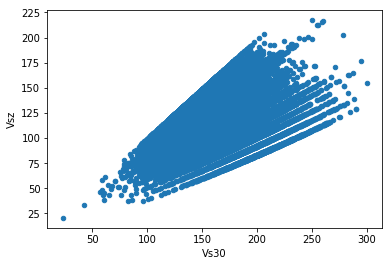

In [11]:
result_df = pd.DataFrame.from_dict(results, orient="index")
result_df.to_csv(out_dir / "vs30_results.csv")

ll = geo.wgs_nztm2000x(result_df[["NZTM_X", "NZTM_Y"]])
result_df["lon"] = ll[:, 0]
result_df["lat"] = ll[:, 1]

result_df.plot.scatter("Vs30", "Vsz")
fig = plt.gcf()
fig.savefig(plot_dir / "vs30_vsz_scatter.png")